***
<font size="6"><center><b> H-CapsNet: A Capsule Network for Hierarchical Image Classification </b></center></font>
***

# Model Description

**H-CapsNet model:**
- Use Capsule network for hierarchcial classification
- This model contains a deducated feature extraction layer and Capsule netowrk per hierarchy
- For training use MixupData data augmentation technique
- Model Uses Dynamic LossWeight Distribution system
- This model is designed and evaluted using **TensorFlow 2.8.0**

# Import necessary Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K
# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
    # ML model, Dataset and evalution metrics
from src import datasets
from src import MLmodel
from src import metrics
from src import MixUp
from src import sysenv
    # For developind (reloades any python scripts)
import importlib
# importlib.reload(MLmodel)
    ##reload APIs
%load_ext autoreload
%autoreload 2

DONE loading Datasets
DONE loading MixUp Data generator


# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = 30BFPC1AXW95
• Working Directory = C:\Users\knoor\OneDrive - Deakin University\Deep Learning with Python\Google_Drive\Projects\Deep Learning\H-CapsNet
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : py38tf


# Training parameters

## Parameters

In [3]:
train_params = {"n_epochs" : 100,
                "batch_size": 32,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"P_Cap_Dim" : 8, # Primary Capsule Dimentions
                "S_Cap_Dim" : 16, # Secondary Capsule Dimention
                "Reconstruction_LW" : 0.0005, # Decoder loss weight
                "class_loss" : MLmodel.MarginLoss(), ## Class prediction loss
                "reconstruction_loss" : 'mse'
               }

# MNIST dataset

## Import MNIST dataset

MNIST dataset: Training have 60,000 samples and testing have 10,000 samples
dict_keys(['x_train', 'y_train_coarse', 'y_train_fine', 'x_test', 'y_test_coarse', 'y_test_fine', 'tree', 'name'])
Root
├── Coarse_0
│   ├── Fine_0
│   └── Fine_6
├── Coarse_1
│   ├── Fine_2
│   └── Fine_8
├── Coarse_2
│   ├── Fine_1
│   └── Fine_7
├── Coarse_3
│   ├── Fine_4
│   └── Fine_9
└── Coarse_4
    ├── Fine_3
    └── Fine_5

INPUT SHAPE: (28, 28, 1) 

TRAIN: 

(60000, 28, 28, 1)
(60000, 10)
(60000, 5)

TEST: 

(10000, 28, 28, 1)
(10000, 10)
(10000, 5)

Number of Classes in Label Tree: 
Coarse Level =  5 
Fine Level =  10


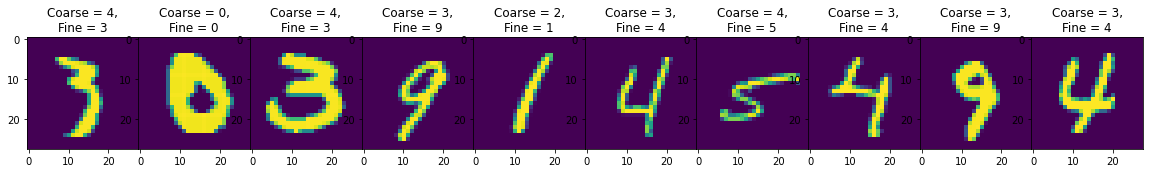

In [4]:
## Import dataset
dataset = datasets.MNIST()
print(dataset.keys())
dataset['tree'].show()


input_shape = dataset['x_train'].shape[1:]
print('INPUT SHAPE:',input_shape,'\n')

print("TRAIN: \r\n")
print(dataset['x_train'].shape)
print(dataset['y_train_fine'].shape)
print(dataset['y_train_coarse'].shape)

print("\nTEST: \r\n")
print(dataset['x_test'].shape)
print(dataset['y_test_fine'].shape)
print(dataset['y_test_coarse'].shape)

fine_class = len(np.unique(np.argmax(dataset['y_test_fine'], axis=1)))
coarse_class = len(np.unique(np.argmax(dataset['y_test_coarse'], axis=1)))
print('\nNumber of Classes in Label Tree:',
      '\nCoarse Level = ',coarse_class,
      '\nFine Level = ',fine_class)

    # Plot Random samples 
datasets.plot_sample_image(dataset['x_train'],
                           {'coarse':dataset['y_train_coarse'],
                            'fine':dataset['y_train_fine']})

## Create ML Model

### Model parameters

In [5]:
initial_lw = MLmodel.initial_lw({"coarse": coarse_class, "fine": fine_class})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : model_params['Reconstruction_LW']
             }

def get_compiled_model():
    model = MLmodel.HCapsNet_2_Level_MNIST(input_shape,
                                   coarse_class, fine_class)
    model.compile(optimizer='adam',
                  loss=[model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["reconstruction_loss"]],
                  loss_weights=[lossweight['coarse_lw'],
                                lossweight['fine_lw'],
                                lossweight['decoder_lw']],
                  metrics={'Fine_prediction_output_layer': 'accuracy',
                           'Coarse_prediction_output_layer': 'accuracy'}
                 )
    return model

Model: "H-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 26, 26, 32)   320         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 26, 26, 32)  128         ['conv1[0][0]']                  
 alization)                                                                                       
                                                                                                  
 conv2 (Conv2D)                 (None, 24, 24, 64)   18496       ['batch_normalization[0][

Trainable params: 10,382,577
Non-trainable params: 3,008
__________________________________________________________________________________________________


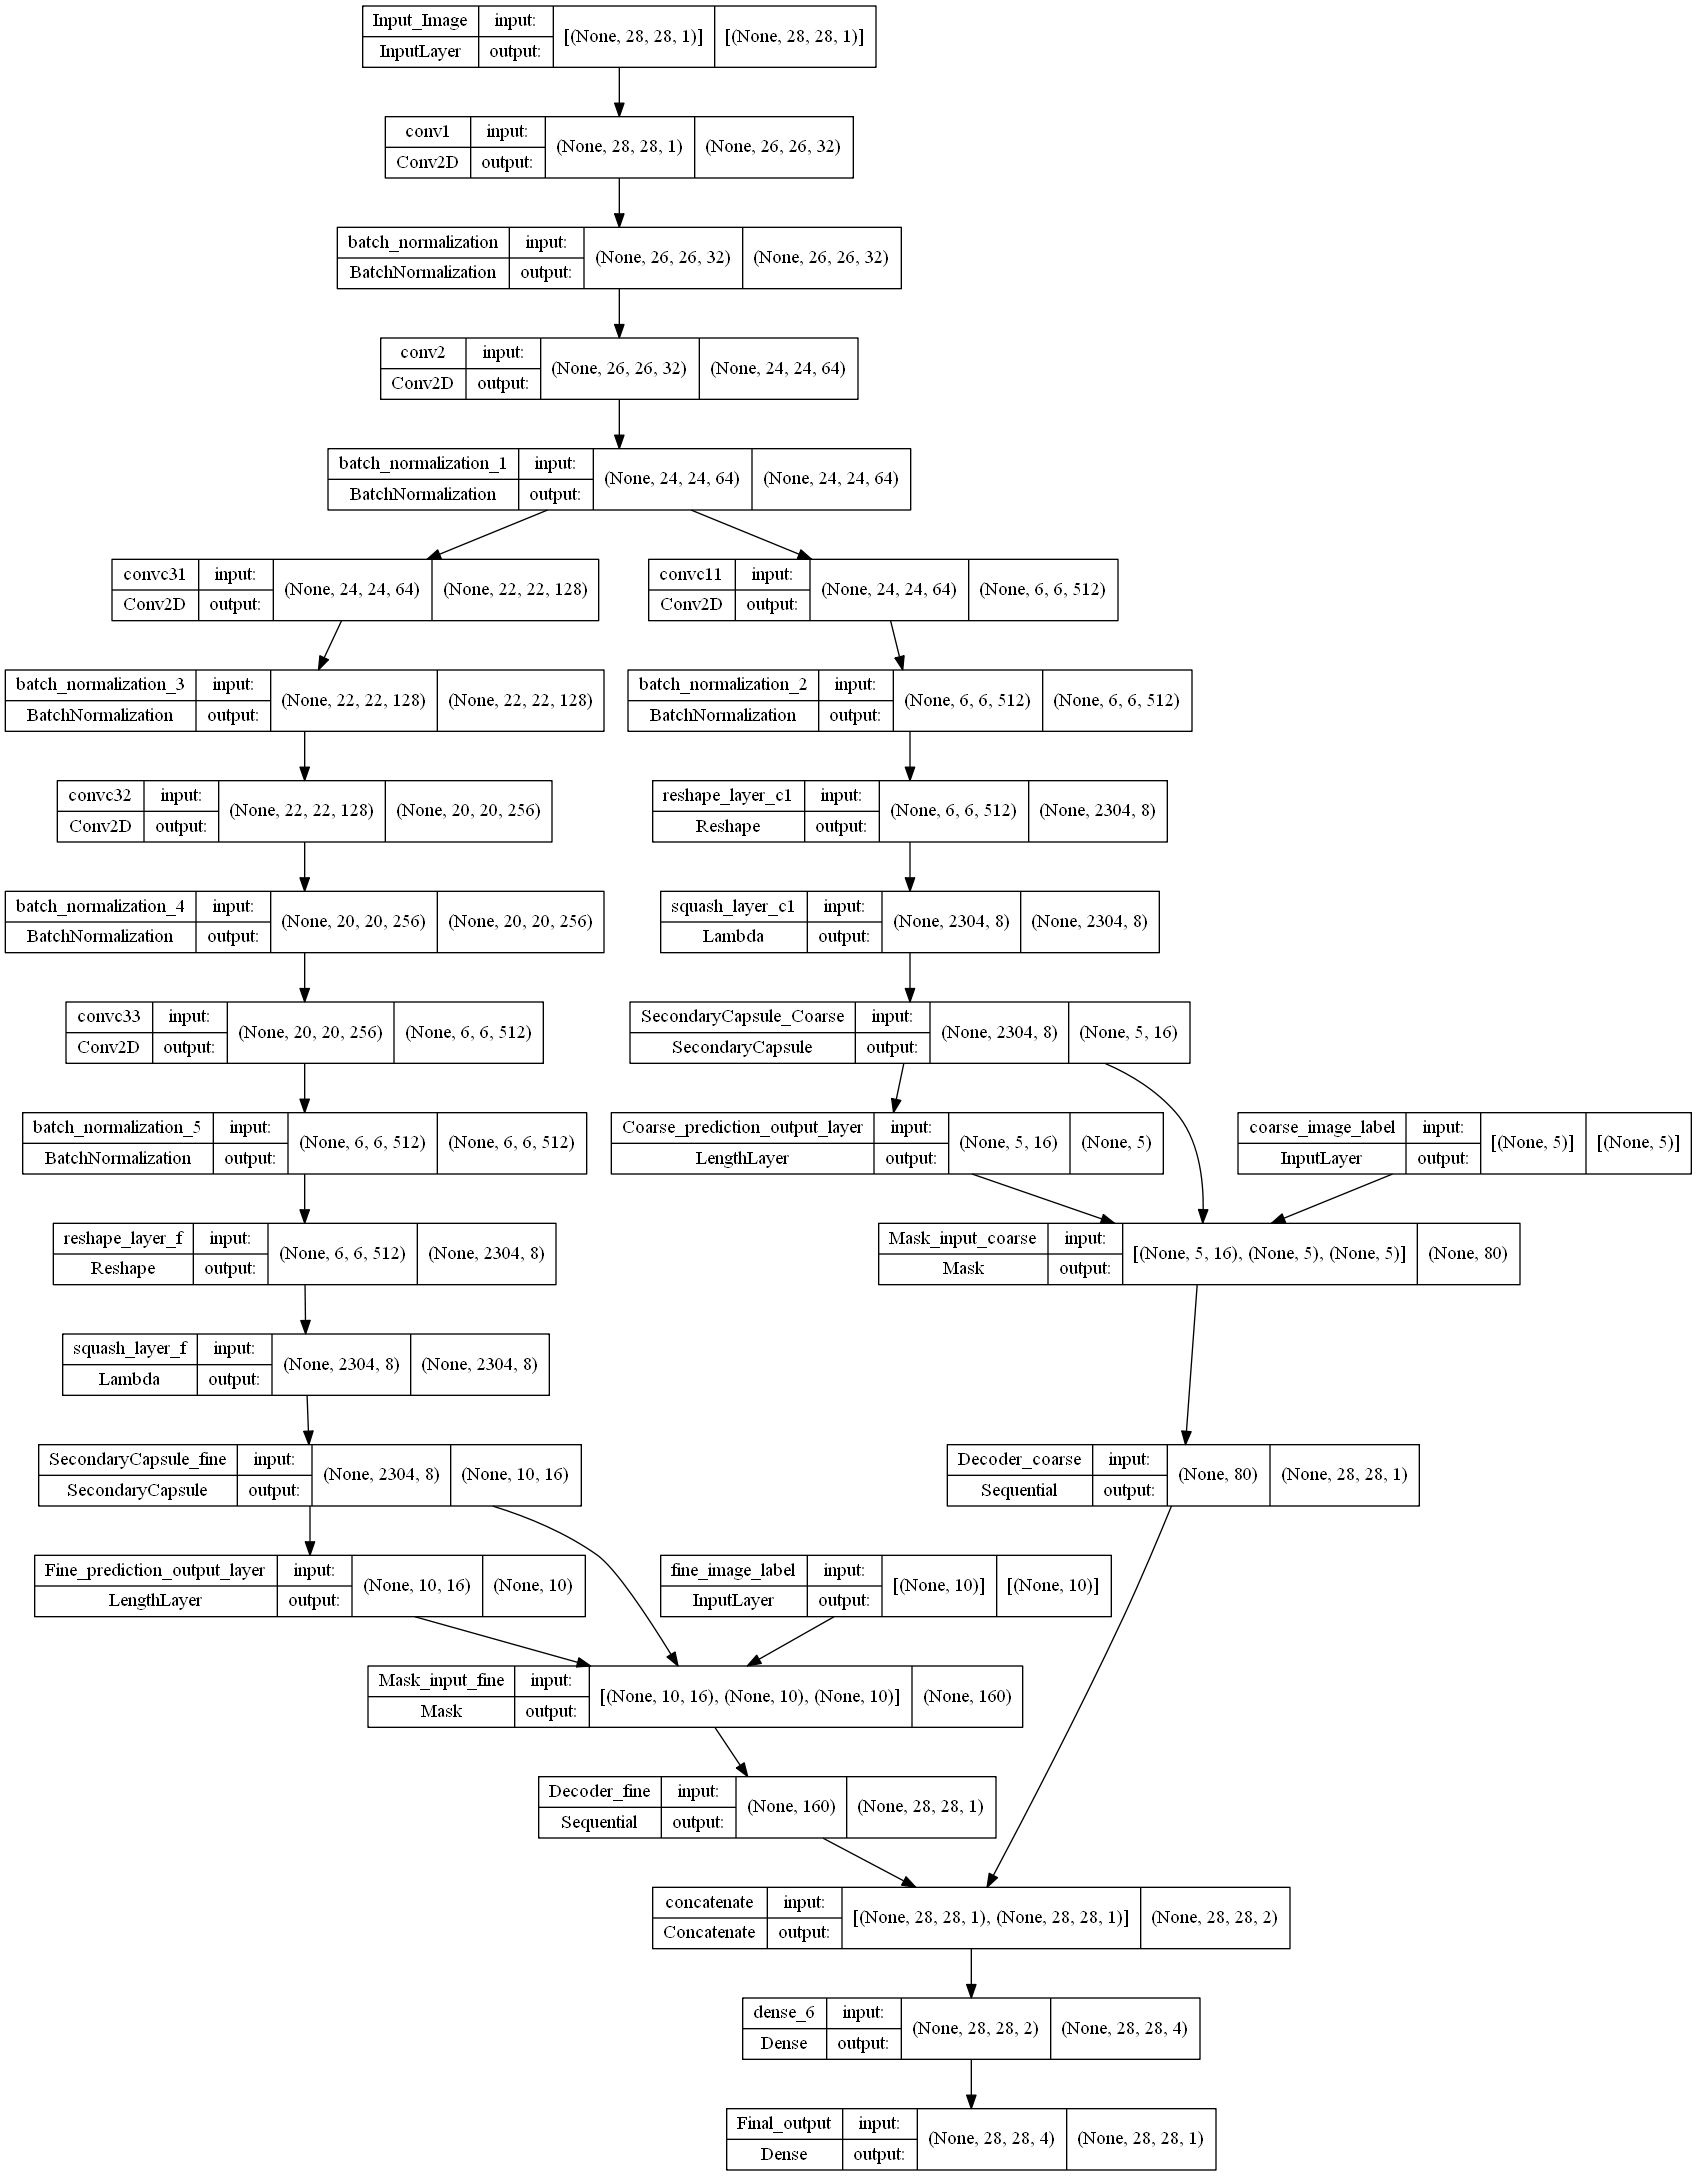

In [6]:
tf.keras.backend.clear_session() ## clear session

model = get_compiled_model()

### Log directory
directory = sysenv.log_dir(dataset["name"]+'/'+model.name)

model.summary()
keras.utils.plot_model(model, to_file = directory+"/H-CapsNet.png", show_shapes=True)

## Model load weight

In [7]:
model.load_weights(directory+'/trained_model.h5')

## Model Analysis

157/157 [==============================] - 12s 44ms/step - loss: 0.0035 - Coarse_prediction_output_layer_loss: 0.0032 - Fine_prediction_output_layer_loss: 0.0041 - Final_output_loss: 0.0376 - Coarse_prediction_output_layer_accuracy: 0.9977 - Fine_prediction_output_layer_accuracy: 0.9958
1. loss ==> 0.003530758200213313
2. Coarse_prediction_output_layer_loss ==> 0.0032226417679339647
3. Fine_prediction_output_layer_loss ==> 0.004090624395757914
4. Final_output_loss ==> 0.03757922723889351
5. Coarse_prediction_output_layer_accuracy ==> 0.9976999759674072
6. Fine_prediction_output_layer_accuracy ==> 0.9958000183105469
157/157 [==============================] - 7s 41ms/step
  • Confusion_Matrix 

  • COARSE LEVEL 
[[1931    3    4    0    0]
 [   1 1998    3    1    3]
 [   0    2 2161    0    0]
 [   0    2    0 1989    0]
 [   2    1    1    0 1898]]

  • FINE LEVEL 
[[ 980    0    0    0    0    0    0    0    0    0]
 [   0 1134    0    0    0    0    0    1    0    0]
 [   0    0 1029

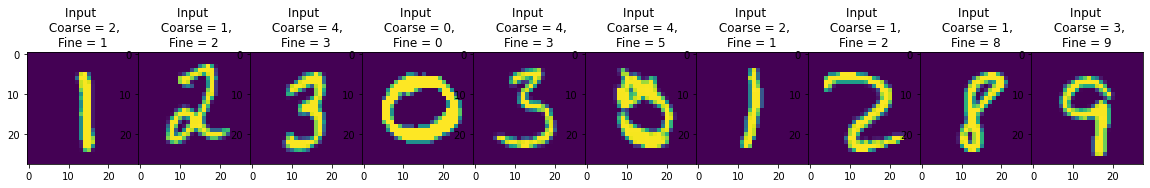

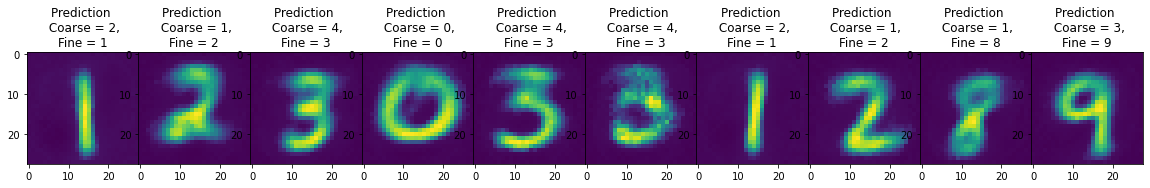

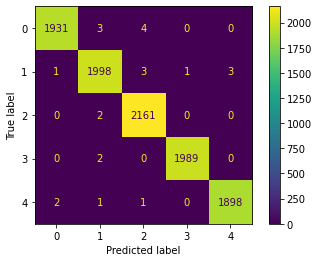

              precision    recall  f1-score   support

           0    0.99845   0.99639   0.99742      1938
           1    0.99601   0.99601   0.99601      2006
           2    0.99631   0.99908   0.99769      2163
           3    0.99950   0.99900   0.99925      1991
           4    0.99842   0.99790   0.99816      1902

    accuracy                        0.99770     10000
   macro avg    0.99774   0.99767   0.99771     10000
weighted avg    0.99770   0.99770   0.99770     10000


  • FINE LEVEL 


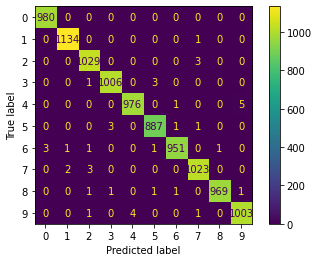

              precision    recall  f1-score   support

           0    0.99695   1.00000   0.99847       980
           1    0.99736   0.99912   0.99824      1135
           2    0.99324   0.99709   0.99516      1032
           3    0.99604   0.99604   0.99604      1010
           4    0.99592   0.99389   0.99490       982
           5    0.99439   0.99439   0.99439       892
           6    0.99686   0.99269   0.99477       958
           7    0.99417   0.99514   0.99465      1028
           8    0.99897   0.99487   0.99691       974
           9    0.99405   0.99405   0.99405      1009

    accuracy                        0.99580     10000
   macro avg    0.99580   0.99573   0.99576     10000
weighted avg    0.99580   0.99580   0.99580     10000


Hierarchical Precision = 0.9968 
Hierarchical Recall = 0.99745 
Hierarchical F1-Score = 0.9970600000000001 
Consistency =  0.9975 
Exact Match =  0.9944


In [8]:
model_analysis = MLmodel.model_analysis(model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

true_label = [dataset['y_test_coarse'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1]]
metrics.lvl_wise_metric(true_label,pred_label)

h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )

# EMNIST Dataset

## Import EMNIST dataset

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']
Complete loading training samples as: x_train, y_train
Complete loading test samples as: x_test, y_test
EMNIST dataset: Training have 112,800 samples and testing have 18,800 samples
dict_keys(['x_train', 'y_train_coarse', 'y_train_fine', 'x_test', 'y_test_coarse', 'y_test_fine', 'tree', 'name'])
Root
├── Coarse_0
│   ├── Fine_0
│   ├── Fine_1
│   ├── Fine_2
│   ├── Fine_3
│   ├── Fine_4
│   ├── Fine_5
│   ├── Fine_6
│   ├── Fine_7
│   ├── Fine_8
│   └── Fine_9
└── Coarse_1
    ├── Fine_10
    ├── Fine_11
    ├── Fine_12
    ├── Fine_13
    ├── Fine_14
    ├── Fine_15
    ├── Fine_16
    ├── Fine_17
    ├── Fine_18
    ├── Fine_19
    ├── Fine_20
    ├── Fine_21
    ├── Fine_22
    ├── Fine_23
    ├── Fine_24
    ├── Fine_25
    ├── Fine_26
    ├── Fine_27
    ├── Fine_28
    ├── Fine_29
    ├── Fine_30
    ├── Fine_31
    ├── Fine_32
    ├── Fine_33
    ├── Fine_34
    ├── Fine_35
    ├── Fine_36
    ├── Fine_37
    ├── F

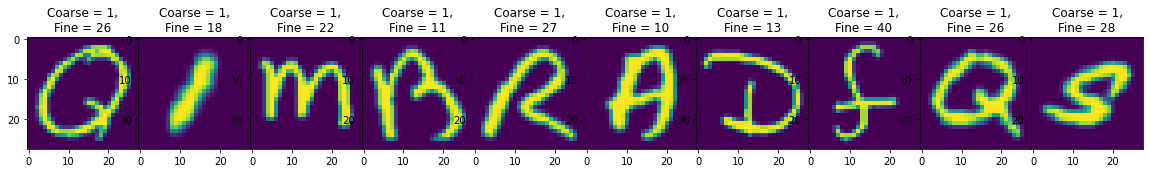

In [9]:
## Import dataset
dataset = datasets.E_MNIST()
print(dataset.keys())
dataset['tree'].show()

input_shape = dataset['x_train'].shape[1:]
print('INPUT SHAPE:',input_shape,'\n')

print("TRAIN: \r\n")
print(dataset['x_train'].shape)
print(dataset['y_train_fine'].shape)
print(dataset['y_train_coarse'].shape)

print("\nTEST: \r\n")
print(dataset['x_test'].shape)
print(dataset['y_test_fine'].shape)
print(dataset['y_train_coarse'].shape)

fine_class = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))
coarse_class = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
print('\nNumber of Classes in Label Tree:',
      '\nCoarse Level = ',coarse_class,
      '\nFine Level = ',fine_class)
    # Plot Random samples 
datasets.plot_sample_image(dataset['x_train'],
                           {'coarse':dataset['y_train_coarse'],
                            'fine':dataset['y_train_fine']})

## Create ML Model

### Model parameters

In [10]:
initial_lw = MLmodel.initial_lw({"coarse": coarse_class, "fine": fine_class})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : model_params['Reconstruction_LW']
             }

def get_compiled_model():
    model = MLmodel.HCapsNet_2_Level_EMNIST_test(input_shape,
                                   coarse_class, fine_class)
    model.compile(optimizer='adam',
                  loss=[model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["reconstruction_loss"]],
                  loss_weights=[lossweight['coarse_lw'],
                                lossweight['fine_lw'],
                                lossweight['decoder_lw']],
                  metrics={'Fine_prediction_output_layer': 'accuracy',
                           'Coarse_prediction_output_layer': 'accuracy'}
                 )
    return model

Model: "H-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 26, 26, 32)   320         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 26, 26, 32)  128         ['conv1[0][0]']                  
 alization)                                                                                       
                                                                                                  
 conv2 (Conv2D)                 (None, 24, 24, 64)   18496       ['batch_normalization[0][

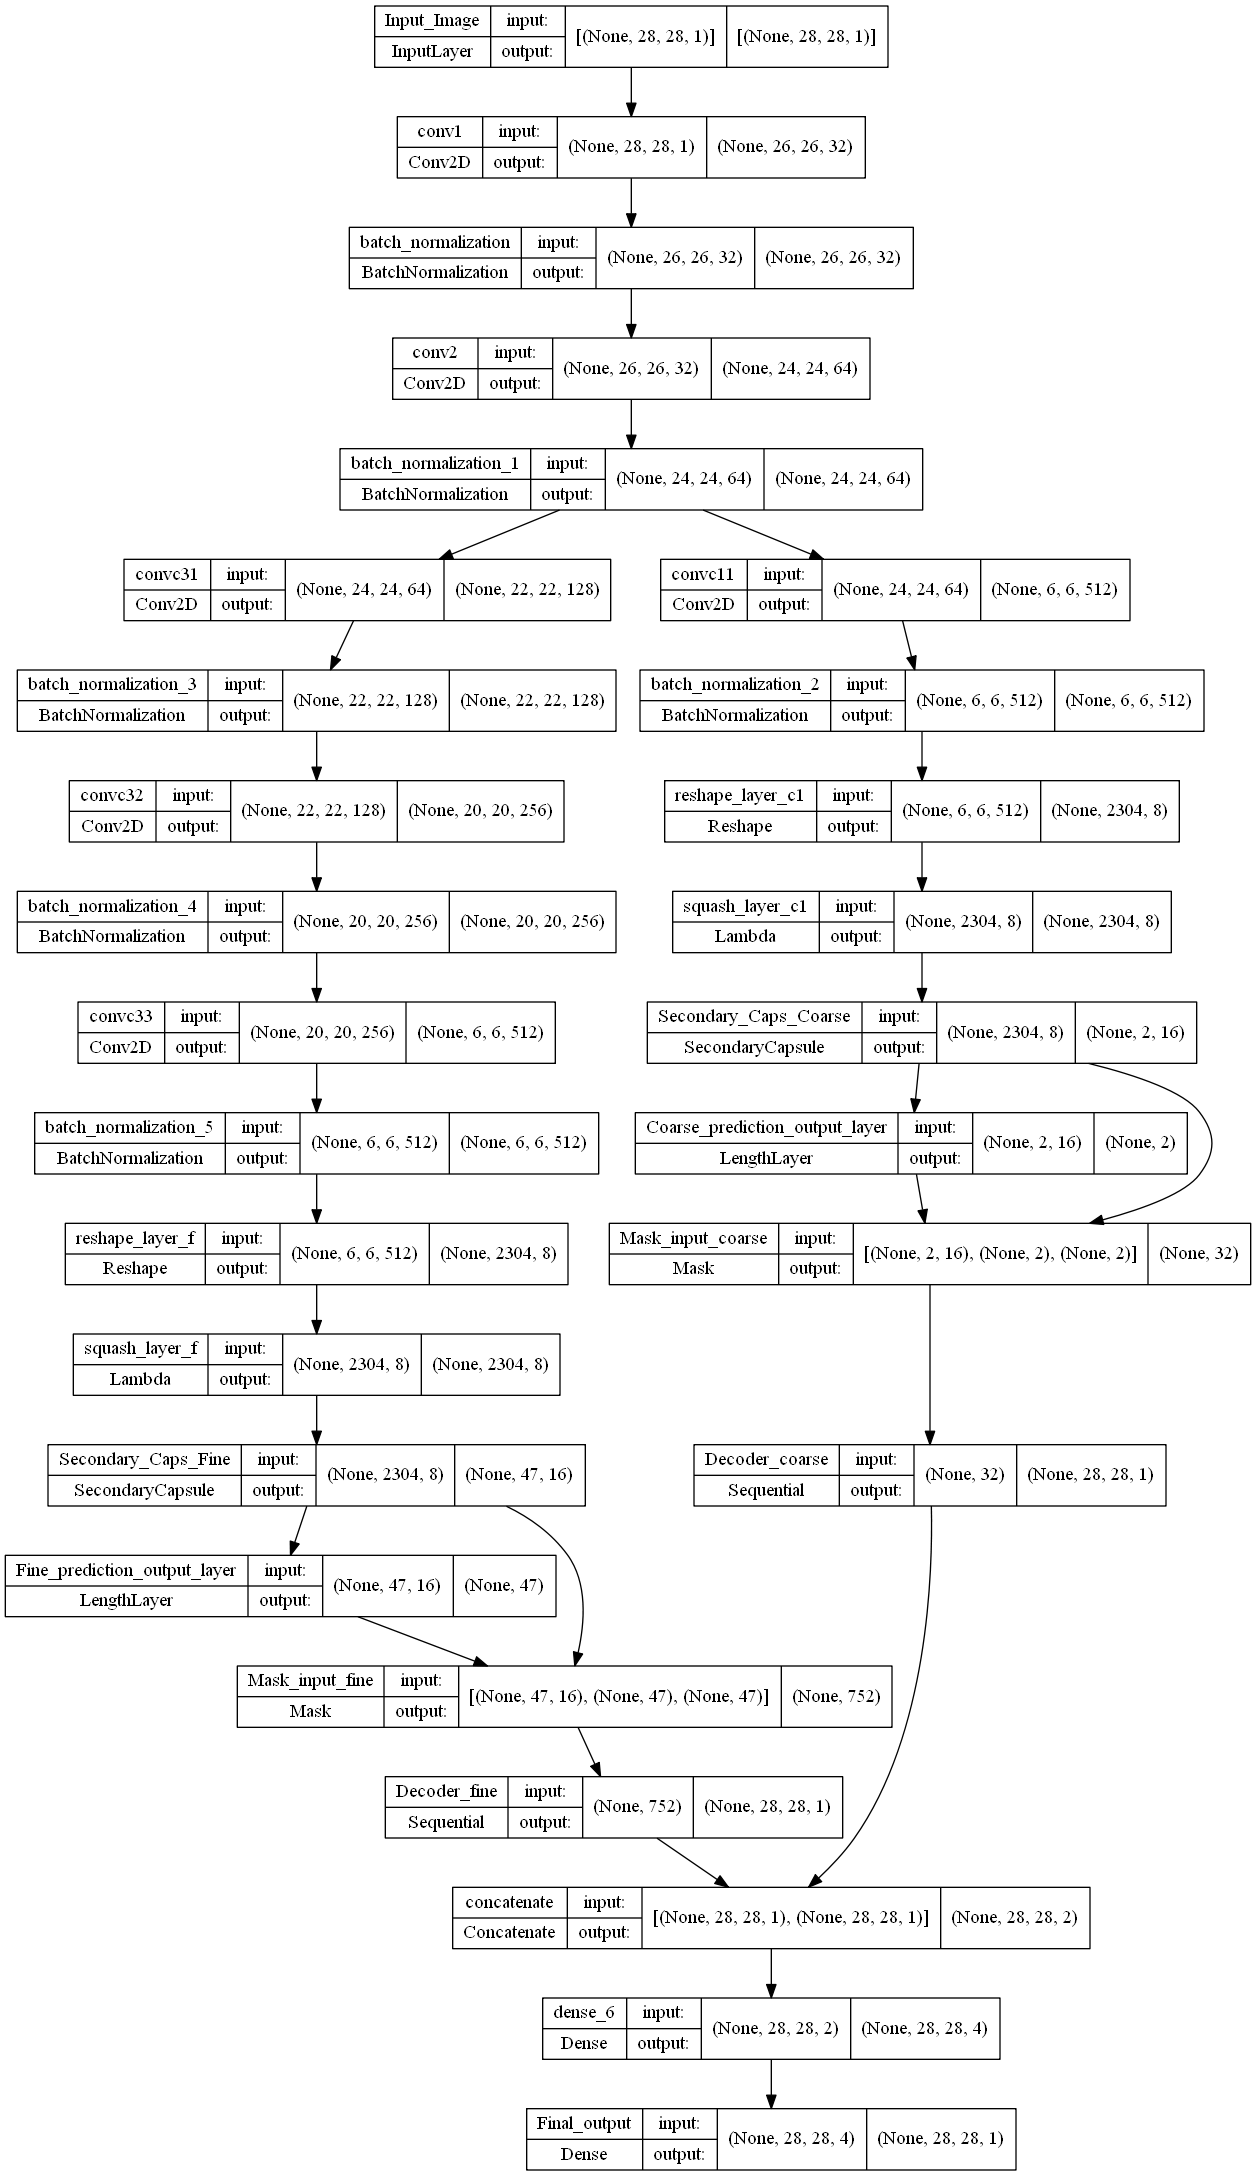

In [11]:
tf.keras.backend.clear_session() ## clear session

model = get_compiled_model()

### Log directory
directory = sysenv.log_dir(dataset["name"]+'/'+model.name)

model.summary()
keras.utils.plot_model(model, to_file = directory+"/H-CapsNet.png", show_shapes=True)

## Model load weight

In [12]:
model.load_weights(directory+'/trained_model.h5')

## Model Analysis

588/588 [==============================] - 35s 57ms/step
  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 3137   863]
 [  397 14403]]

  • FINE LEVEL 
[[297   0   0 ...   0   0   0]
 [  0 220   0 ...   0   0   0]
 [  0   0 346 ...   0   0   0]
 ...
 [  0   0   0 ... 259   0   0]
 [  0   0   0 ...   0 371   2]
 [  0   0   0 ...   0   1 370]]

  • Classification Report 


  • COARSE LEVEL 


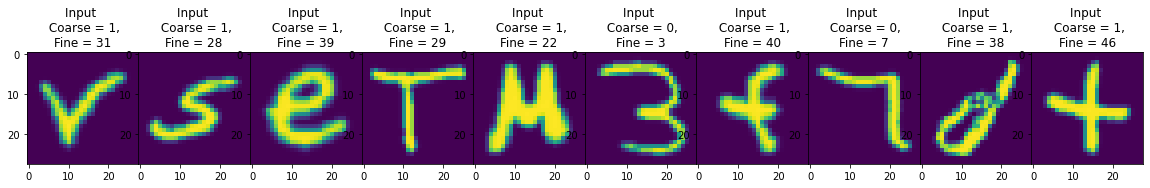

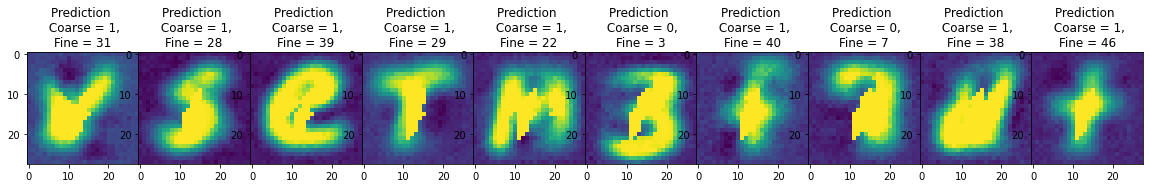

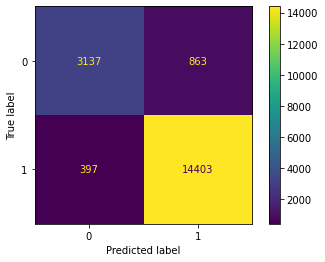

              precision    recall  f1-score   support

           0    0.88766   0.78425   0.83276      4000
           1    0.94347   0.97318   0.95809     14800

    accuracy                        0.93298     18800
   macro avg    0.91557   0.87871   0.89543     18800
weighted avg    0.93160   0.93298   0.93143     18800


  • FINE LEVEL 


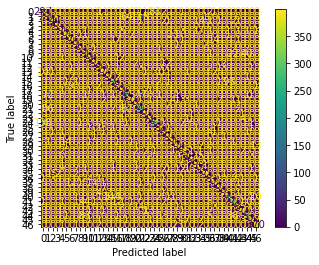

              precision    recall  f1-score   support

           0    0.66742   0.74250   0.70296       400
           1    0.58047   0.55000   0.56483       400
           2    0.94278   0.86500   0.90222       400
           3    0.99254   0.99750   0.99501       400
           4    0.95455   0.94500   0.94975       400
           5    0.95630   0.93000   0.94297       400
           6    0.94000   0.94000   0.94000       400
           7    0.97304   0.99250   0.98267       400
           8    0.96806   0.98500   0.97646       400
           9    0.71702   0.84250   0.77471       400
          10    0.97537   0.99000   0.98263       400
          11    0.98000   0.98000   0.98000       400
          12    0.96750   0.96750   0.96750       400
          13    0.91546   0.94750   0.93120       400
          14    0.98995   0.98500   0.98747       400
          15    0.66593   0.75250   0.70657       400
          16    0.93046   0.97000   0.94982       400
          17    0.96577   0

In [13]:
results = model.evaluate(dataset['x_test'],[dataset['y_test_coarse'],dataset['y_test_fine'],dataset['x_test']],
                         verbose=1)
predictions = model.predict(dataset['x_test'],verbose=1)

MLmodel.plot_sample_image(predictions,
                  x_input = dataset['x_test'],
                  y_labels = {'coarse':dataset['y_test_coarse'],
                              'fine':dataset['y_test_fine']})

true_label = [dataset['y_test_coarse'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1]]
metrics.lvl_wise_metric(true_label,pred_label)

h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )

# Fashion-MNIST dataset

## Import Fashion-MNIST dataset

Fashion-MNIST dataset: Training have 60,000 samples and testing have 10,000 samples
dict_keys(['x_train', 'y_train_coarse', 'y_train_medium', 'y_train_fine', 'x_test', 'y_test_coarse', 'y_test_medium', 'y_test_fine', 'tree', 'name'])
Root
├── Coarse_0
│   ├── Medium0
│   │   ├── Fine_0
│   │   ├── Fine_2
│   │   └── Fine_6
│   ├── Medium1
│   │   └── Fine_1
│   ├── Medium2
│   │   └── Fine_3
│   └── Medium3
│       └── Fine_4
└── Coarse_1
    ├── Medium4
    │   └── Fine_8
    └── Medium5
        ├── Fine_5
        ├── Fine_7
        └── Fine_9

INPUT SHAPE: (28, 28, 1) 

TRAIN: 

(60000, 28, 28, 1)
(60000, 10)
(60000, 6)
(60000, 2)

TEST: 

(10000, 28, 28, 1)
(10000, 10)
(10000, 6)
(10000, 2)

Number of Classes in Label Tree: 
Coarse Level =  2 
Medium Level =  6 
Fine Level =  10


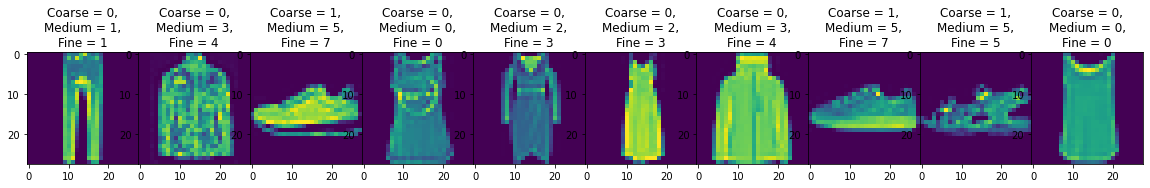

In [14]:
## Import dataset
dataset = datasets.F_MNIST()
print(dataset.keys())
dataset['tree'].show()

input_shape = dataset['x_train'].shape[1:]
print('INPUT SHAPE:',input_shape,'\n')

print("TRAIN: \r\n")
print(dataset['x_train'].shape)
print(dataset['y_train_fine'].shape)
print(dataset['y_train_medium'].shape)
print(dataset['y_train_coarse'].shape)

print("\nTEST: \r\n")
print(dataset['x_test'].shape)
print(dataset['y_test_fine'].shape)
print(dataset['y_test_medium'].shape)
print(dataset['y_test_coarse'].shape)

fine_class = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))
medium_class = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
coarse_class = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
print('\nNumber of Classes in Label Tree:',
      '\nCoarse Level = ',coarse_class,
      '\nMedium Level = ',medium_class,
      '\nFine Level = ',fine_class)

datasets.plot_sample_image(dataset['x_train'],
                           {'coarse':dataset['y_train_coarse'],
                            'medium':dataset['y_train_medium'],
                            'fine':dataset['y_train_fine']})

### Model parameters

In [15]:
initial_lw = MLmodel.initial_lw({"coarse": coarse_class,
                                 "medium": medium_class,
                                 "fine": fine_class})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : model_params['Reconstruction_LW']
             }

def get_compiled_model():
    model = MLmodel.HCapsNet_3_Level_FMNIST_test(input_shape,
                                     coarse_class, medium_class, fine_class)
    model.compile(optimizer='adam',
                  loss=[model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["reconstruction_loss"]],
                  loss_weights=[lossweight['coarse_lw'],
                                lossweight['medium_lw'],
                                lossweight['fine_lw'],
                                lossweight['decoder_lw']],
                  metrics={'Fine_prediction_output_layer': 'accuracy',
                           'Medium_prediction_output_layer': 'accuracy',
                           'Coarse_prediction_output_layer': 'accuracy'}
                 )
    return model

Model: "H-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 26, 26, 32)   320         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 26, 26, 32)  128         ['conv1[0][0]']                  
 alization)                                                                                       
                                                                                                  
 conv2 (Conv2D)                 (None, 24, 24, 64)   18496       ['batch_normalization[0][

                                                                  'Fine_prediction_output_layer[0]
                                                                 [0]']                            
                                                                                                  
 Mask_input_coarse2 (Mask)      (None, 96)           0           ['Secondary_Caps_Medium[0][0]',  
                                                                  'Medium_prediction_output_layer[
                                                                 0][0]',                          
                                                                  'Medium_prediction_output_layer[
                                                                 0][0]']                          
                                                                                                  
 Mask_input_coarse1 (Mask)      (None, 32)           0           ['Secondary_Caps_Coarse[0][0]',  
          

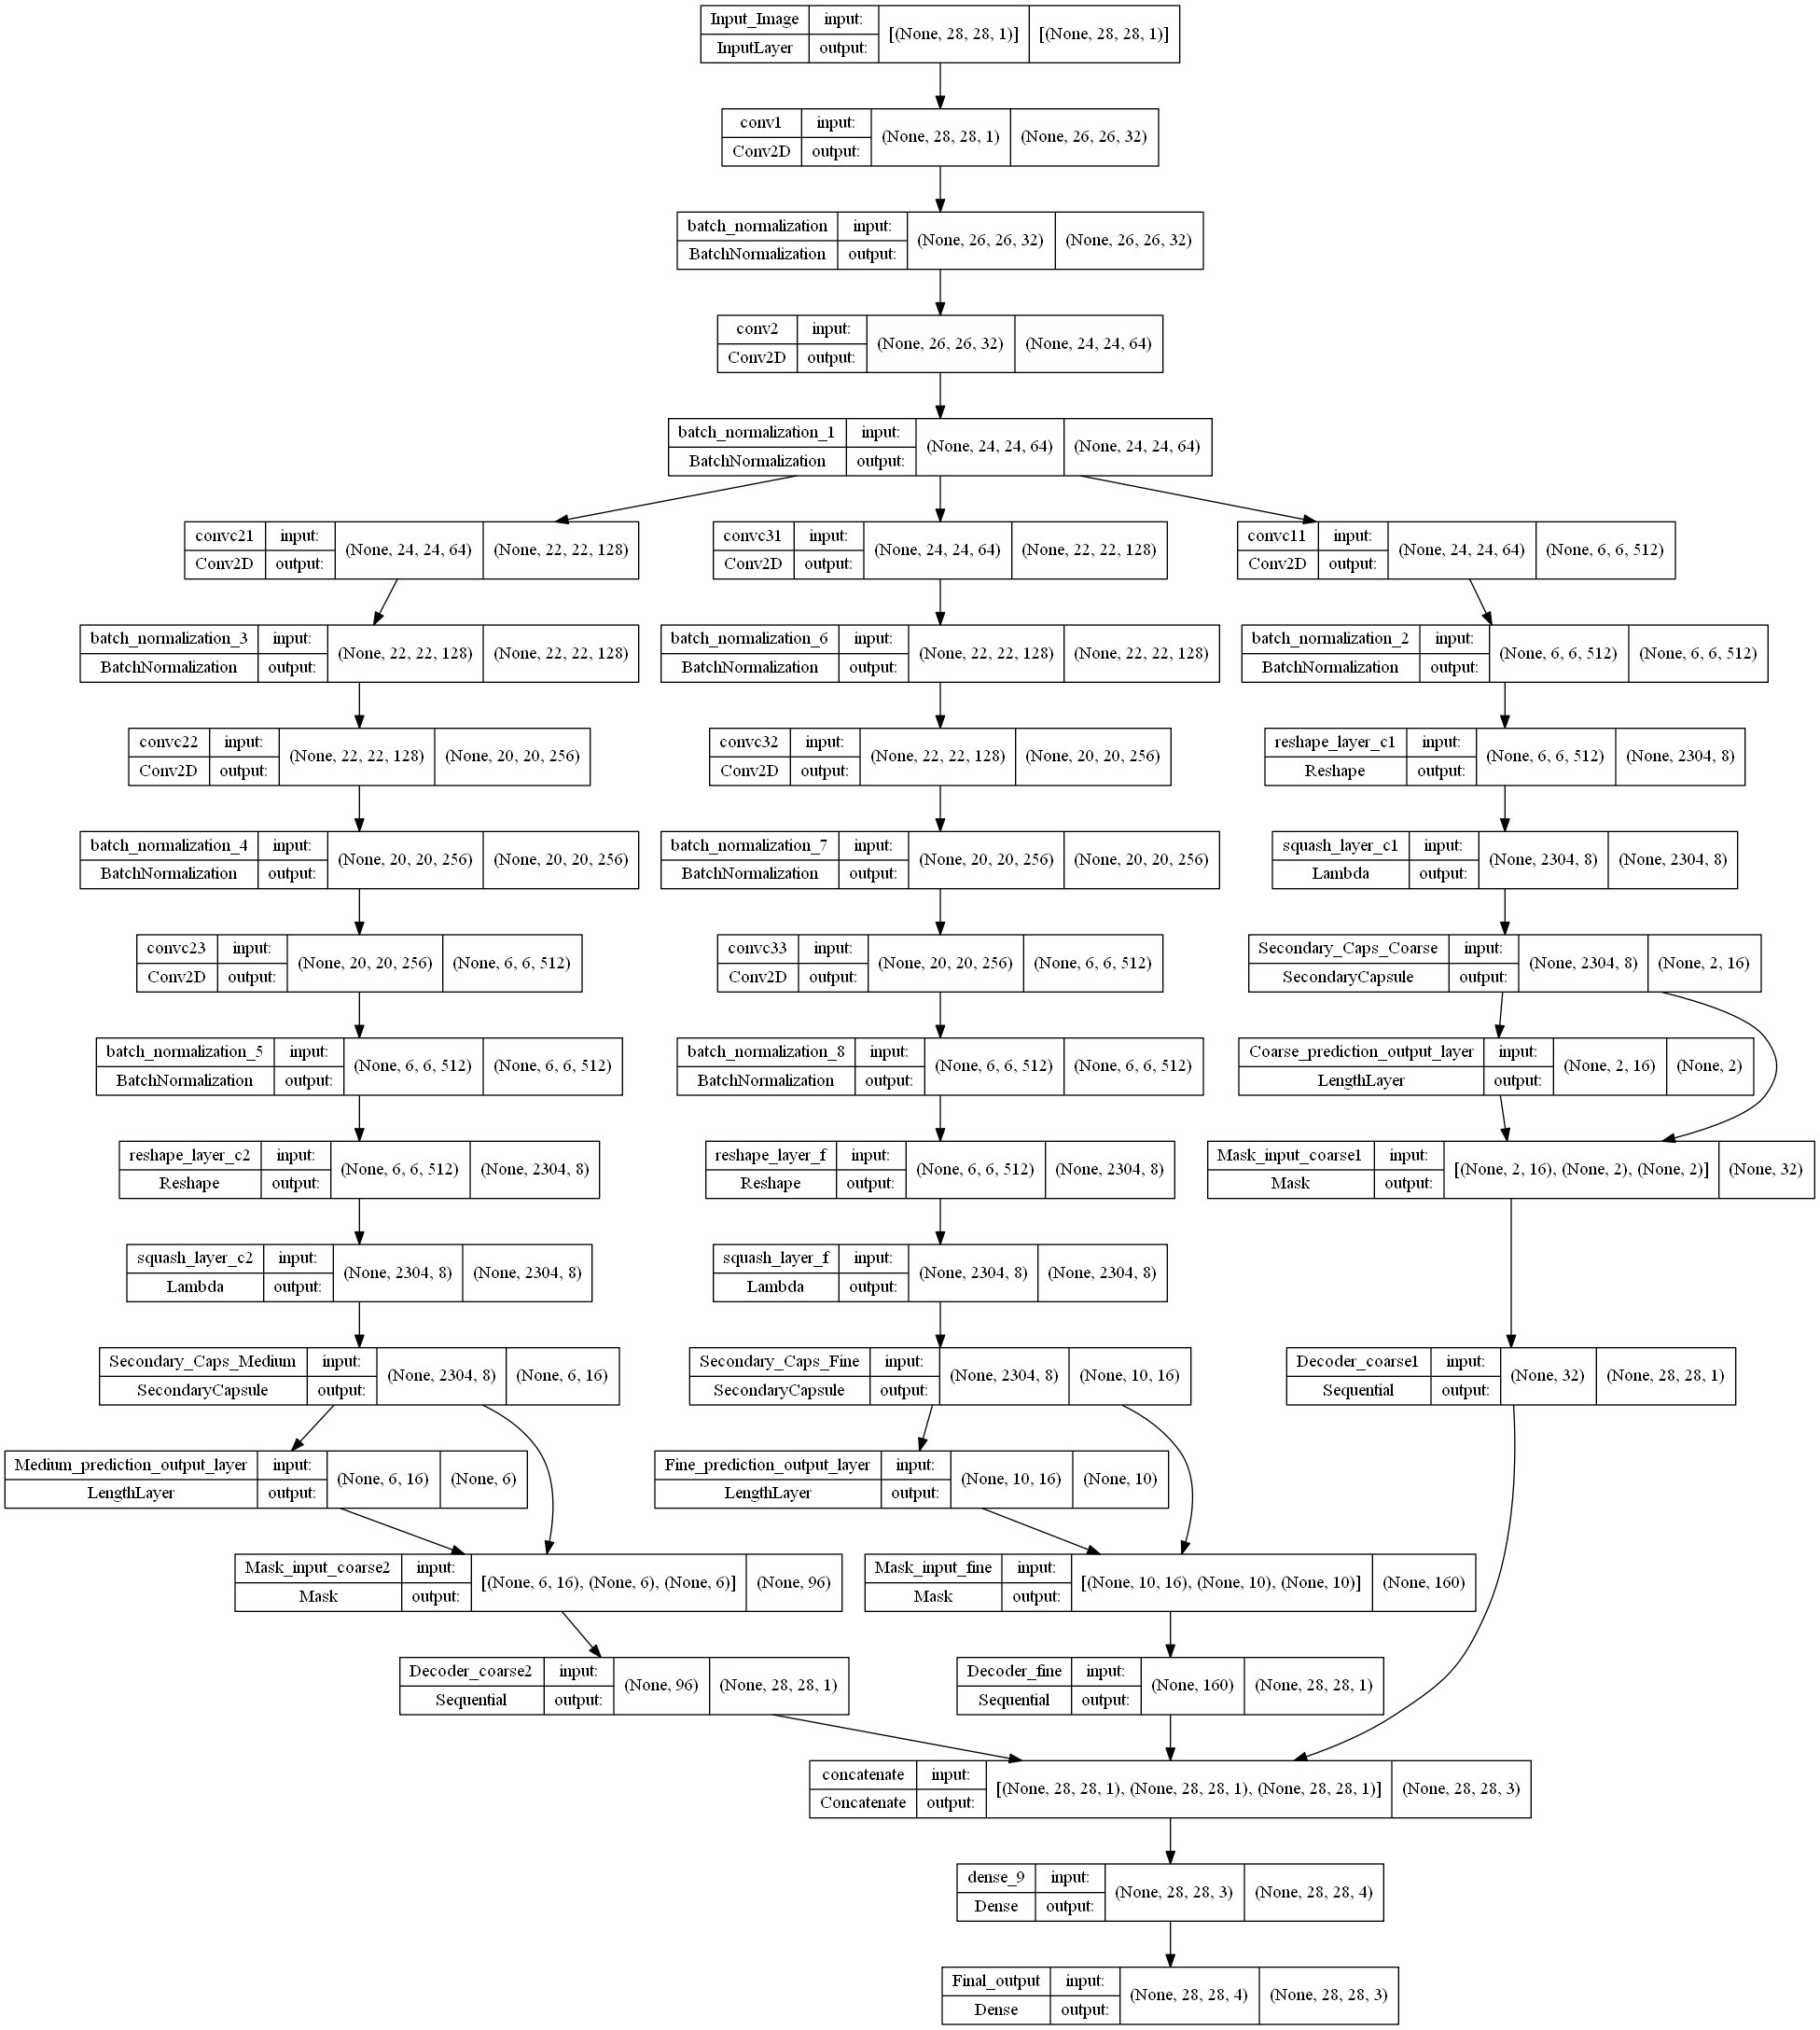

In [16]:
tf.keras.backend.clear_session() ## clear session

model = get_compiled_model()

### Log directory
directory = sysenv.log_dir(dataset["name"]+'/'+model.name)

model.summary()
keras.utils.plot_model(model, to_file = directory+"/H-CapsNet.png", show_shapes=True)

## Model load weight

In [17]:
model.load_weights(directory+'/trained_model.h5')

## Model Analysis

313/313 [==============================] - 11s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

  • Confusion_Matrix 

  • COARSE LEVEL 
[[5987   13]
 [  14 3986]]

  • MEDIUM LEVEL 
[[2904    2   30   59    4    1]
 [   4  985    7    3    1    0]
 [  65    2  918   14    1    0]
 [  81    0   13  906    0    0]
 [   3    0    1    1  993    2]
 [   0    0    0    0    0 3000]]

  • FINE LEVEL 
[[900   0  13  15   2   0  67   0   3   0]
 [  1 989   1   7   1   0   0   0   1   0]
 [ 14   1 901  10  24   0  50   0   0   0]
 [ 12   2   9 949  10   0  17   0   1   0]
 [  1   1  25  14 913   0  46   0   0   0]
 [  0   0   0   0   0 985   0  11   0   4]
 [ 89   1  24  18  45   0 817   0   6   0]
 [  0   0   0   0   0   4   0 983   0  13]
 [  0   1   0   1   1   1   0   0 996   0]
 [  0   0   0   0   0   8   0  30   0 962]]

  • Classification Report 


  • COARSE LEVEL 


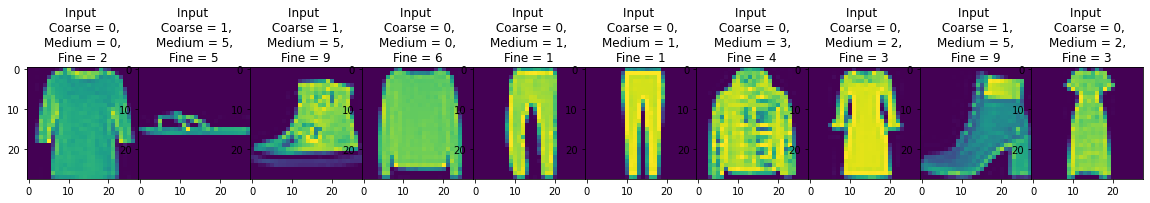

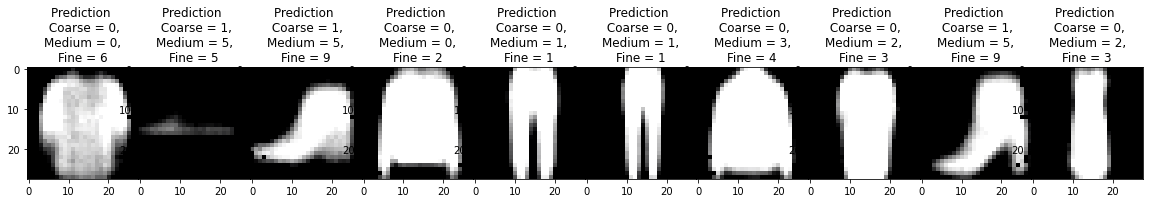

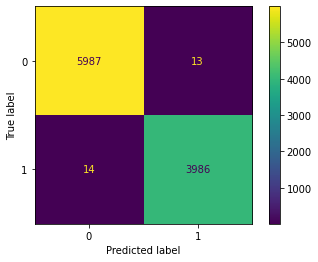

              precision    recall  f1-score   support

           0    0.99767   0.99783   0.99775      6000
           1    0.99675   0.99650   0.99662      4000

    accuracy                        0.99730     10000
   macro avg    0.99721   0.99717   0.99719     10000
weighted avg    0.99730   0.99730   0.99730     10000


  • MEDIUM LEVEL 


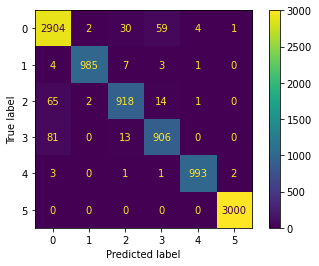

              precision    recall  f1-score   support

           0    0.94995   0.96800   0.95889      3000
           1    0.99596   0.98500   0.99045      1000
           2    0.94737   0.91800   0.93245      1000
           3    0.92167   0.90600   0.91377      1000
           4    0.99399   0.99300   0.99350      1000
           5    0.99900   1.00000   0.99950      3000

    accuracy                        0.97060     10000
   macro avg    0.96799   0.96167   0.96476     10000
weighted avg    0.97058   0.97060   0.97053     10000


  • FINE LEVEL 


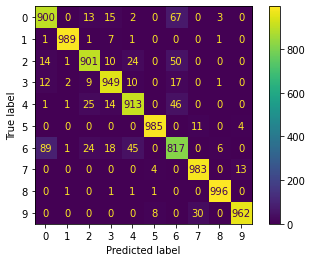

              precision    recall  f1-score   support

           0    0.88496   0.90000   0.89241      1000
           1    0.99397   0.98900   0.99148      1000
           2    0.92600   0.90100   0.91333      1000
           3    0.93590   0.94900   0.94240      1000
           4    0.91667   0.91300   0.91483      1000
           5    0.98697   0.98500   0.98599      1000
           6    0.81946   0.81700   0.81823      1000
           7    0.95996   0.98300   0.97134      1000
           8    0.98908   0.99600   0.99253      1000
           9    0.98264   0.96200   0.97221      1000

    accuracy                        0.93950     10000
   macro avg    0.93956   0.93950   0.93947     10000
weighted avg    0.93956   0.93950   0.93947     10000


Hierarchical Precision = 0.9685799999999999 
Hierarchical Recall = 0.9736333333333334 
Hierarchical F1-Score = 0.9707285714285714 
Consistency =  0.976 
Exact Match =  0.9269


In [18]:
results = model.evaluate(dataset['x_test'],
                         [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine'],dataset['x_test']],
                         verbose=1)
predictions = model.predict(dataset['x_test'],verbose=1)

MLmodel.plot_sample_image(predictions,
                  x_input = dataset['x_test'],
                  y_labels = {'coarse':dataset['y_test_coarse'],
                              'medium':dataset['y_test_medium'],
                              'fine':dataset['y_test_fine']})

true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )

# CIFAR-10 Dataset

## Import CIFAR-10 dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples
dict_keys(['x_train', 'y_train_coarse', 'y_train_medium', 'y_train_fine', 'x_test', 'y_test_coarse', 'y_test_medium', 'y_test_fine', 'tree', 'name'])
Root
├── Coarse_0
│   ├── Medium0
│   │   └── Fine_0
│   ├── Medium1
│   │   └── Fine_8
│   └── Medium2
│       ├── Fine_1
│       └── Fine_9
└── Coarse_1
    ├── Medium3
    │   └── Fine_2
    ├── Medium4
    │   └── Fine_6
    ├── Medium5
    │   ├── Fine_3
    │   └── Fine_5
    └── Medium6
        ├── Fine_4
        └── Fine_7

INPUT SHAPE: (32, 32, 3) 

TRAIN: 

(50000, 32, 32, 3)
(50000, 10)
(50000, 7)
(50000, 2)

TEST: 

(10000, 32, 32, 3)
(10000, 10)
(10000, 7)
(10000, 2)

Number of Classes in Label Tree: 
Coarse Level =  2 
Medium Level =  7 
Fine Level =  10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

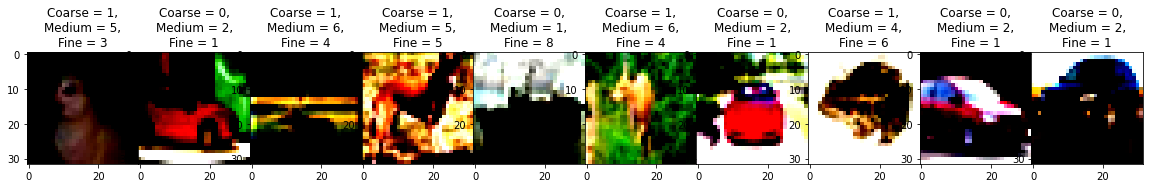

In [19]:
## Import dataset
dataset = datasets.CIFAR10()
print(dataset.keys())
dataset['tree'].show()

input_shape = dataset['x_train'].shape[1:]
print('INPUT SHAPE:',input_shape,'\n')

print("TRAIN: \r\n")
print(dataset['x_train'].shape)
print(dataset['y_train_fine'].shape)
print(dataset['y_train_medium'].shape)
print(dataset['y_train_coarse'].shape)

print("\nTEST: \r\n")
print(dataset['x_test'].shape)
print(dataset['y_test_fine'].shape)
print(dataset['y_test_medium'].shape)
print(dataset['y_test_coarse'].shape)

fine_class = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))
medium_class = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
coarse_class = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
print('\nNumber of Classes in Label Tree:',
      '\nCoarse Level = ',coarse_class,
      '\nMedium Level = ',medium_class,
      '\nFine Level = ',fine_class)
datasets.plot_sample_image(dataset['x_train'],
                           {'coarse':dataset['y_train_coarse'],
                            'medium':dataset['y_train_medium'],
                            'fine':dataset['y_train_fine']})

### Model parameters

In [20]:
initial_lw = MLmodel.initial_lw({"coarse": coarse_class,
                                 "medium": medium_class,
                                 "fine": fine_class})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : model_params['Reconstruction_LW']
             }

def get_compiled_model():
    model = MLmodel.HCapsNet_3_Level_test(input_shape,
                                     coarse_class, medium_class, fine_class)
    model.compile(optimizer='adam',
                  loss=[model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["reconstruction_loss"]],
                  loss_weights=[lossweight['coarse_lw'],
                                lossweight['medium_lw'],
                                lossweight['fine_lw'],
                                lossweight['decoder_lw']],
                  metrics={'Fine_prediction_output_layer': 'accuracy',
                           'Medium_prediction_output_layer': 'accuracy',
                           'Coarse_prediction_output_layer': 'accuracy'}
                 )
    return model

Model: "H-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['encoder_conv_1[0][0]']         
 alization)                                                                                       
                                                                                                  
 encoder_conv_2 (Conv2D)        (None, 32, 32, 64)   36928       ['batch_normalization[0][

 maxpool_2 (MaxPooling2D)       (None, 8, 8, 128)    0           ['batch_normalization_3[0][0]']  
                                                                                                  
 maxpoo_22 (MaxPooling2D)       (None, 4, 4, 256)    0           ['batch_normalization_7[0][0]']  
                                                                                                  
 maxpool_33 (MaxPooling2D)      (None, 2, 2, 512)    0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 reshape_layer_c1 (Reshape)     (None, 1024, 8)      0           ['maxpool_2[0][0]']              
                                                                                                  
 reshape_layer_c2 (Reshape)     (None, 512, 8)       0           ['maxpoo_22[0][0]']              
                                                                                                  
 reshape_l

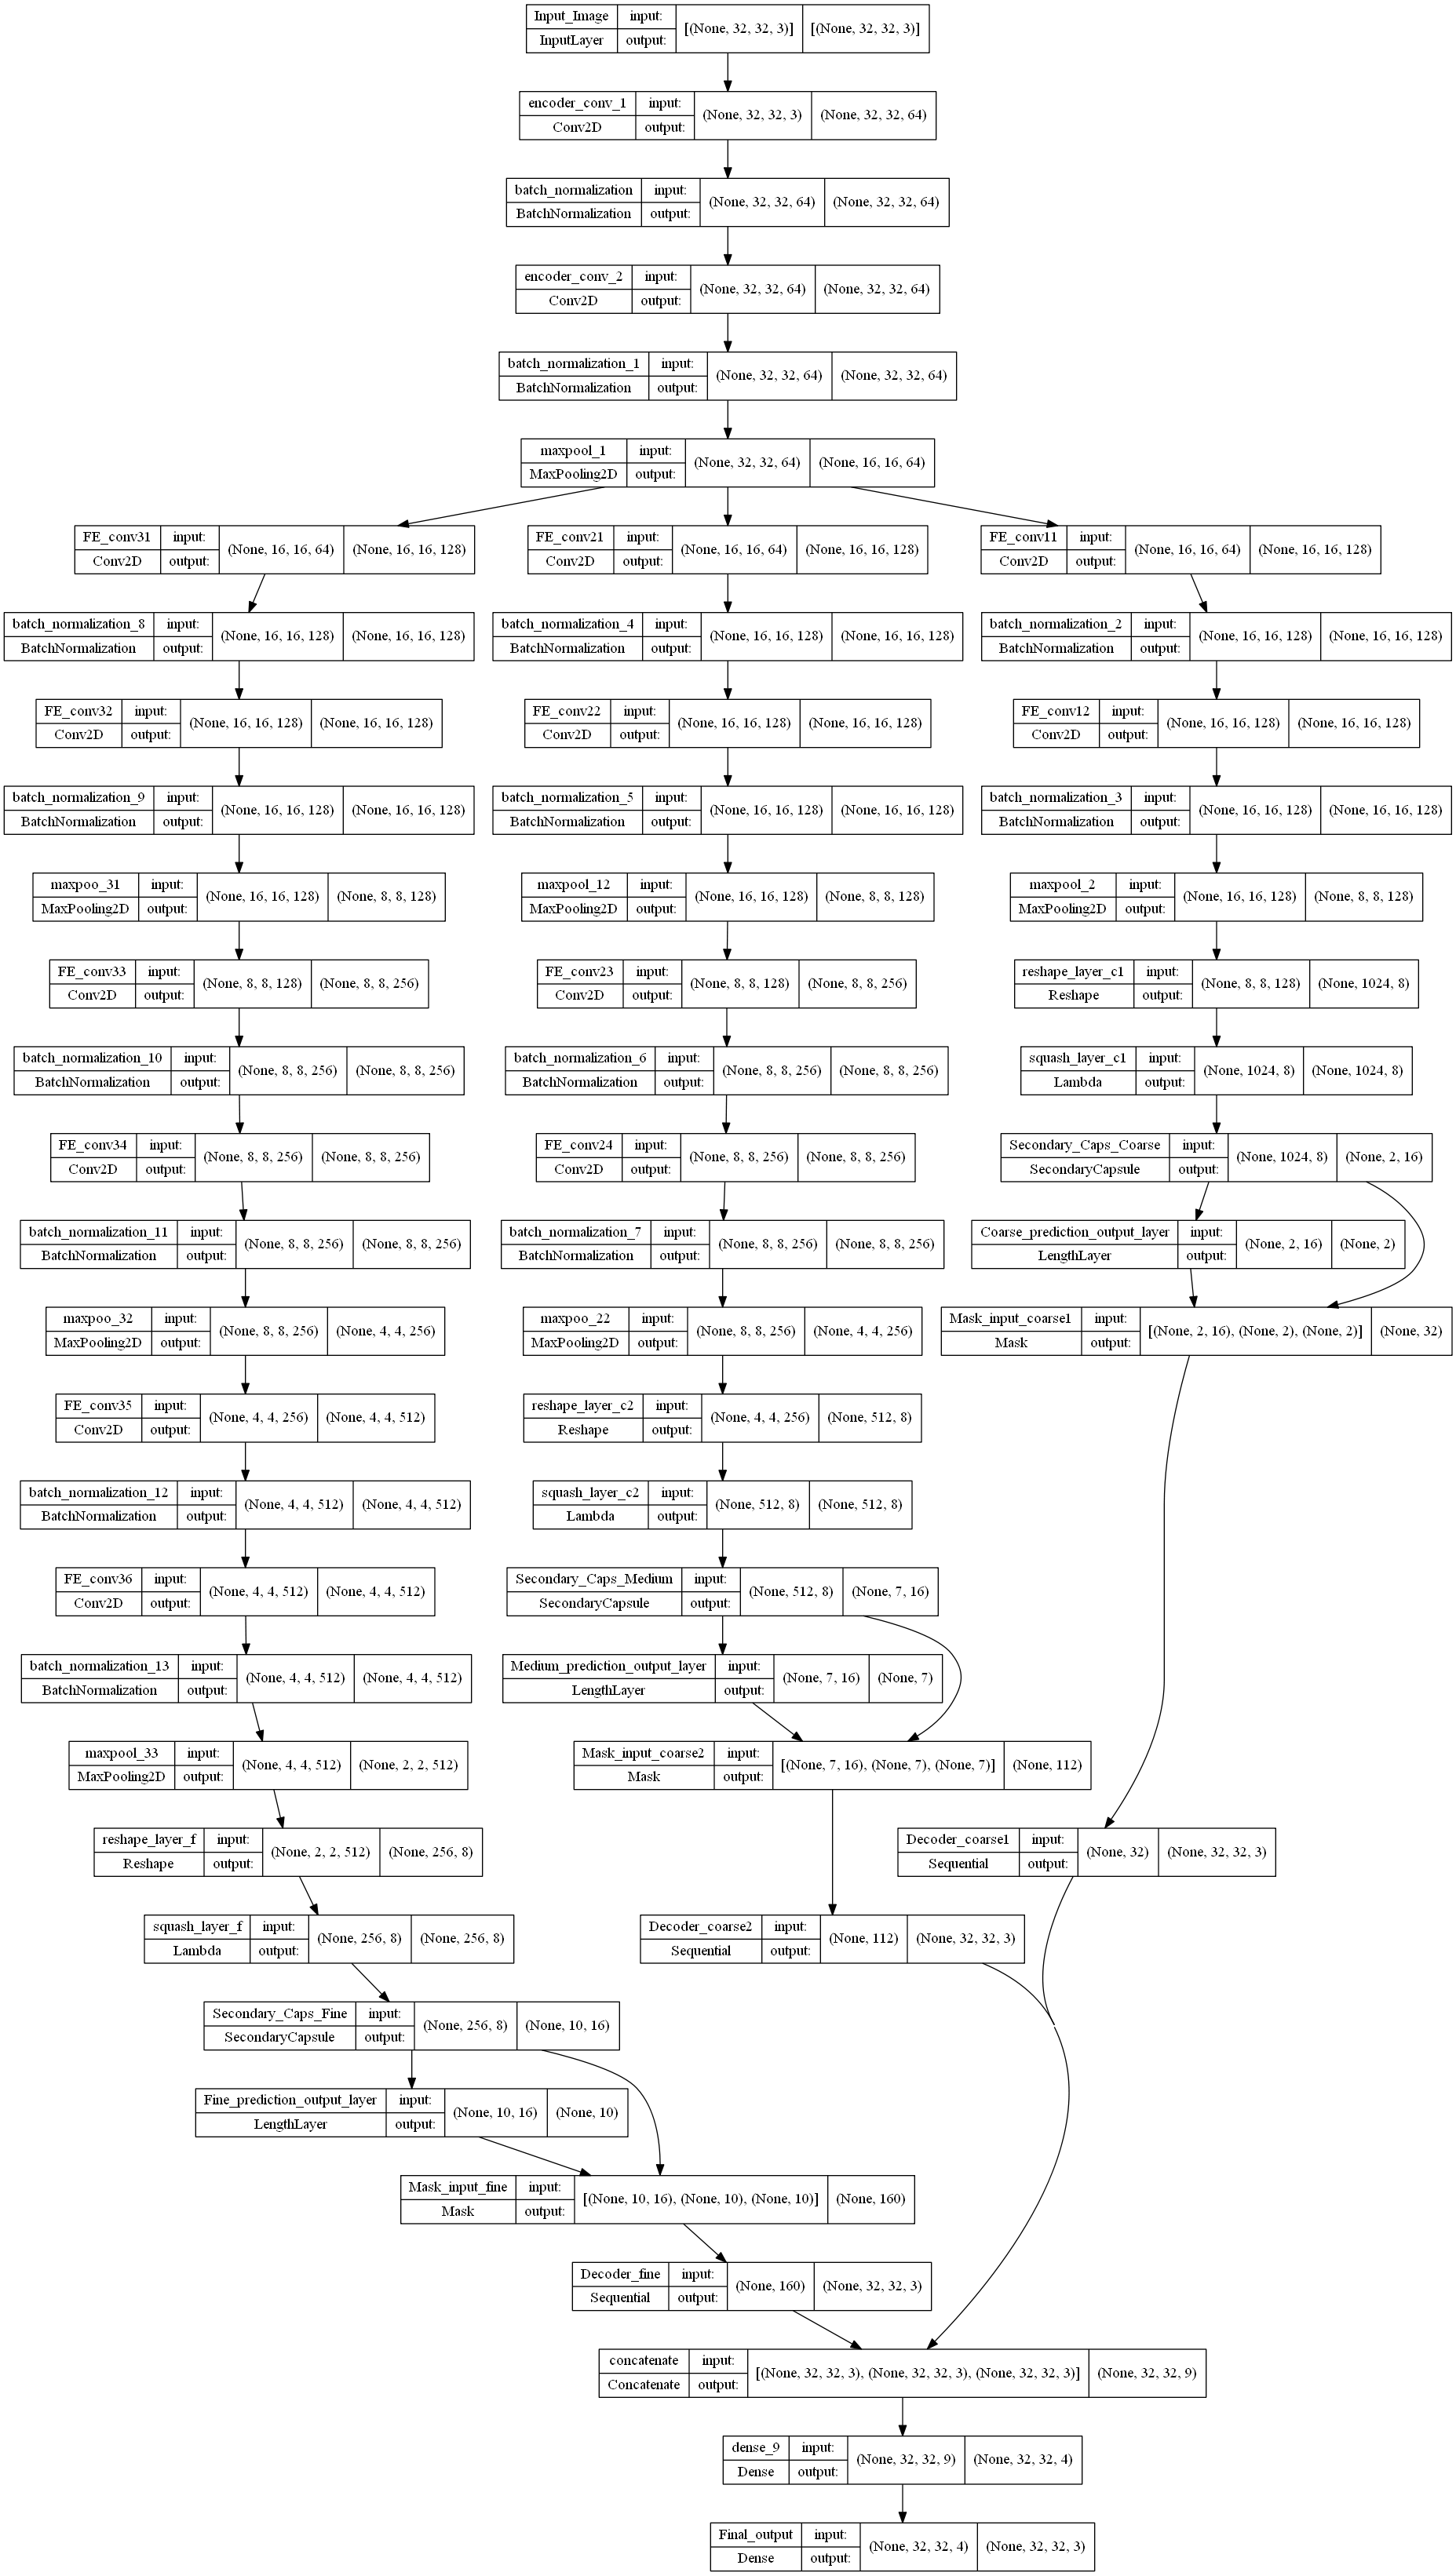

In [21]:
tf.keras.backend.clear_session() ## clear session

model = get_compiled_model()

### Log directory
directory = sysenv.log_dir(dataset["name"]+'/'+model.name)

model.summary()
keras.utils.plot_model(model, to_file = directory+"/H-CapsNet.png", show_shapes=True)

## Model load weight

In [22]:
model.load_weights(directory+'/trained_model.h5')

## Model Analysis

313/313 [==============================] - 7s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3899  101]
 [ 138 5862]]

  • MEDIUM LEVEL 
[[ 916   19   25   19    4    9    8]
 [  34  925   27    3    4    6    1]
 [  14    8 1969    1    2    4    2]
 [  25    1    5  839   32   66   32]
 [   5    0    5   12  944   27    7]
 [  16    3   16   29   46 1826   64]
 [  12    1    5   31   29   83 1839]]

  • FINE LEVEL 
[[938   7  14   4   2   3   3   3  17   9]
 [  4 972   3   1   1   0   0   0   3  16]
 [ 29   0 886  22  15  12  22   9   3   2]
 [ 11   3  26 810  27  74  28  12   4   5]
 [  5   2  27  13 915   5  16  13   3   1]
 [  2   5  16  76  19 856  12  12   1   1]
 [  7   0   8  14   2   4 963   2   0   0]
 [  6   0  10   6  20  14   3 937   1   3]
 [ 29  11   4   2   0   3   1   0 936  14]
 [  4  39   1   2   0   0   1   1   3 949]]

  • Classification Report 


  • COARSE LEVEL 


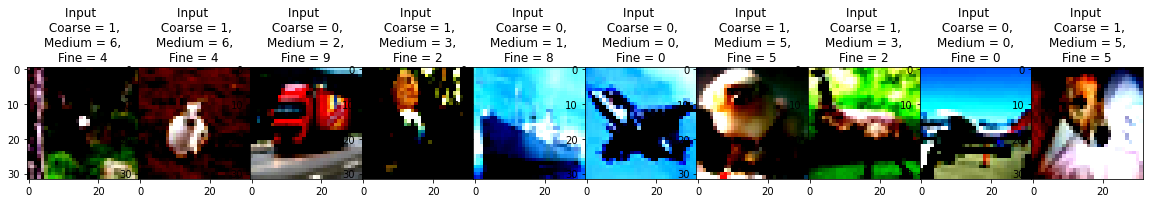

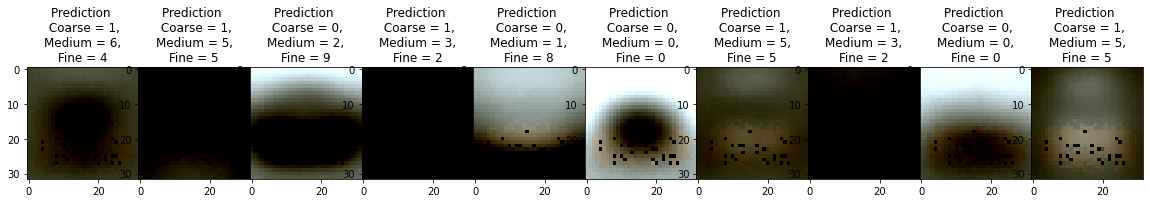

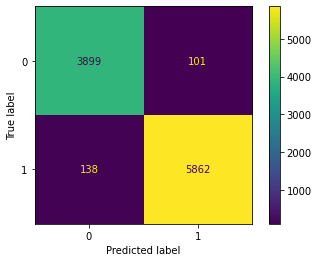

              precision    recall  f1-score   support

           0    0.96582   0.97475   0.97026      4000
           1    0.98306   0.97700   0.98002      6000

    accuracy                        0.97610     10000
   macro avg    0.97444   0.97588   0.97514     10000
weighted avg    0.97616   0.97610   0.97612     10000


  • MEDIUM LEVEL 


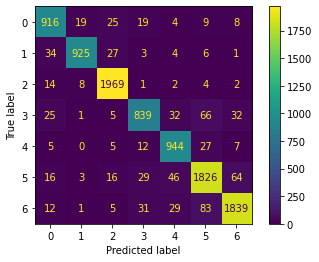

              precision    recall  f1-score   support

           0    0.89628   0.91600   0.90603      1000
           1    0.96656   0.92500   0.94532      1000
           2    0.95955   0.98450   0.97187      2000
           3    0.89829   0.83900   0.86763      1000
           4    0.88973   0.94400   0.91606      1000
           5    0.90351   0.91300   0.90823      2000
           6    0.94163   0.91950   0.93043      2000

    accuracy                        0.92580     10000
   macro avg    0.92222   0.92014   0.92080     10000
weighted avg    0.92602   0.92580   0.92561     10000


  • FINE LEVEL 


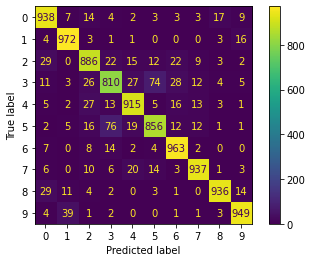

              precision    recall  f1-score   support

           0    0.90628   0.93800   0.92187      1000
           1    0.93551   0.97200   0.95341      1000
           2    0.89045   0.88600   0.88822      1000
           3    0.85263   0.81000   0.83077      1000
           4    0.91409   0.91500   0.91454      1000
           5    0.88157   0.85600   0.86859      1000
           6    0.91802   0.96300   0.93997      1000
           7    0.94742   0.93700   0.94218      1000
           8    0.96395   0.93600   0.94977      1000
           9    0.94900   0.94900   0.94900      1000

    accuracy                        0.91620     10000
   macro avg    0.91589   0.91620   0.91583     10000
weighted avg    0.91589   0.91620   0.91583     10000


Hierarchical Precision = 0.9392316666666666 
Hierarchical Recall = 0.959 
Hierarchical F1-Score = 0.9474095238095238 
Consistency =  0.9124 
Exact Match =  0.8665


In [23]:
results = model.evaluate(dataset['x_test'],
                         [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine'],dataset['x_test']],
                         verbose=1)
predictions = model.predict(dataset['x_test'],verbose=1)

MLmodel.plot_sample_image(predictions,
                  x_input = dataset['x_test'],
                  y_labels = {'coarse':dataset['y_test_coarse'],
                              'medium':dataset['y_test_medium'],
                              'fine':dataset['y_test_fine']})

true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )

# CIFAR-100 Dataset

## Import CIFAR-100 dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples
dict_keys(['x_train', 'y_train_coarse', 'y_train_medium', 'y_train_fine', 'x_test', 'y_test_coarse', 'y_test_medium', 'y_test_fine', 'tree', 'name'])
Root
├── Coarse_0
│   ├── Medium0
│   │   ├── Fine_30
│   │   ├── Fine_4
│   │   ├── Fine_55
│   │   ├── Fine_72
│   │   └── Fine_95
│   └── Medium1
│       ├── Fine_1
│       ├── Fine_32
│       ├── Fine_67
│       ├── Fine_73
│       └── Fine_91
├── Coarse_1
│   ├── Medium17
│   │   ├── Fine_47
│   │   ├── Fine_52
│   │   ├── Fine_56
│   │   ├── Fine_59
│   │   └── Fine_96
│   ├── Medium2
│   │   ├── Fine_54
│   │   ├── Fine_62
│   │   ├── Fine_70
│   │   ├── Fine_82
│   │   └── Fine_92
│   └── Medium4
│       ├── Fine_0
│       ├── Fine_51
│       ├── Fine_53
│       ├── Fine_57
│       └── Fine_83
├── Coarse_2
│   ├── Medium3
│   │   ├── Fine_10
│   │   ├── Fine_16
│   │   ├── Fine_28
│   │   ├── Fine_61
│   │   └── Fine_9
│   ├── Medium5
│   │   ├── Fine_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


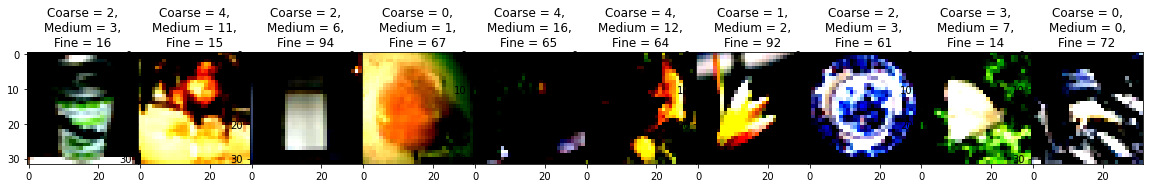

In [24]:
## Import dataset
dataset = datasets.CIFAR100()
print(dataset.keys())
dataset['tree'].show()

input_shape = dataset['x_train'].shape[1:]
print('INPUT SHAPE:',input_shape,'\n')

print("TRAIN: \r\n")
print(dataset['x_train'].shape)
print(dataset['y_train_fine'].shape)
print(dataset['y_train_medium'].shape)
print(dataset['y_train_coarse'].shape)

print("\nTEST: \r\n")
print(dataset['x_test'].shape)
print(dataset['y_test_fine'].shape)
print(dataset['y_test_medium'].shape)
print(dataset['y_test_coarse'].shape)

fine_class = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))
medium_class = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
coarse_class = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
print('\nNumber of Classes in Label Tree:',
      '\nCoarse Level = ',coarse_class,
      '\nMedium Level = ',medium_class,
      '\nFine Level = ',fine_class)

datasets.plot_sample_image(dataset['x_train'],
                           {'coarse':dataset['y_train_coarse'],
                            'medium':dataset['y_train_medium'],
                            'fine':dataset['y_train_fine']})

### Model parameters

In [25]:
initial_lw = MLmodel.initial_lw({"coarse": coarse_class,
                                 "medium": medium_class,
                                 "fine": fine_class})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : model_params['Reconstruction_LW']
             }

def get_compiled_model():
    model = MLmodel.HCapsNet_3_Level_test(input_shape,
                                     coarse_class, medium_class, fine_class)
    model.compile(optimizer='adam',
                  loss=[model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["reconstruction_loss"]],
                  loss_weights=[lossweight['coarse_lw'],
                                lossweight['medium_lw'],
                                lossweight['fine_lw'],
                                lossweight['decoder_lw']],
                  metrics={'Fine_prediction_output_layer': 'accuracy',
                           'Medium_prediction_output_layer': 'accuracy',
                           'Coarse_prediction_output_layer': 'accuracy'}
                 )
    return model

Model: "H-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['encoder_conv_1[0][0]']         
 alization)                                                                                       
                                                                                                  
 encoder_conv_2 (Conv2D)        (None, 32, 32, 64)   36928       ['batch_normalization[0][

 maxpool_2 (MaxPooling2D)       (None, 8, 8, 128)    0           ['batch_normalization_3[0][0]']  
                                                                                                  
 maxpoo_22 (MaxPooling2D)       (None, 4, 4, 256)    0           ['batch_normalization_7[0][0]']  
                                                                                                  
 maxpool_33 (MaxPooling2D)      (None, 2, 2, 512)    0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 reshape_layer_c1 (Reshape)     (None, 1024, 8)      0           ['maxpool_2[0][0]']              
                                                                                                  
 reshape_layer_c2 (Reshape)     (None, 512, 8)       0           ['maxpoo_22[0][0]']              
                                                                                                  
 reshape_l

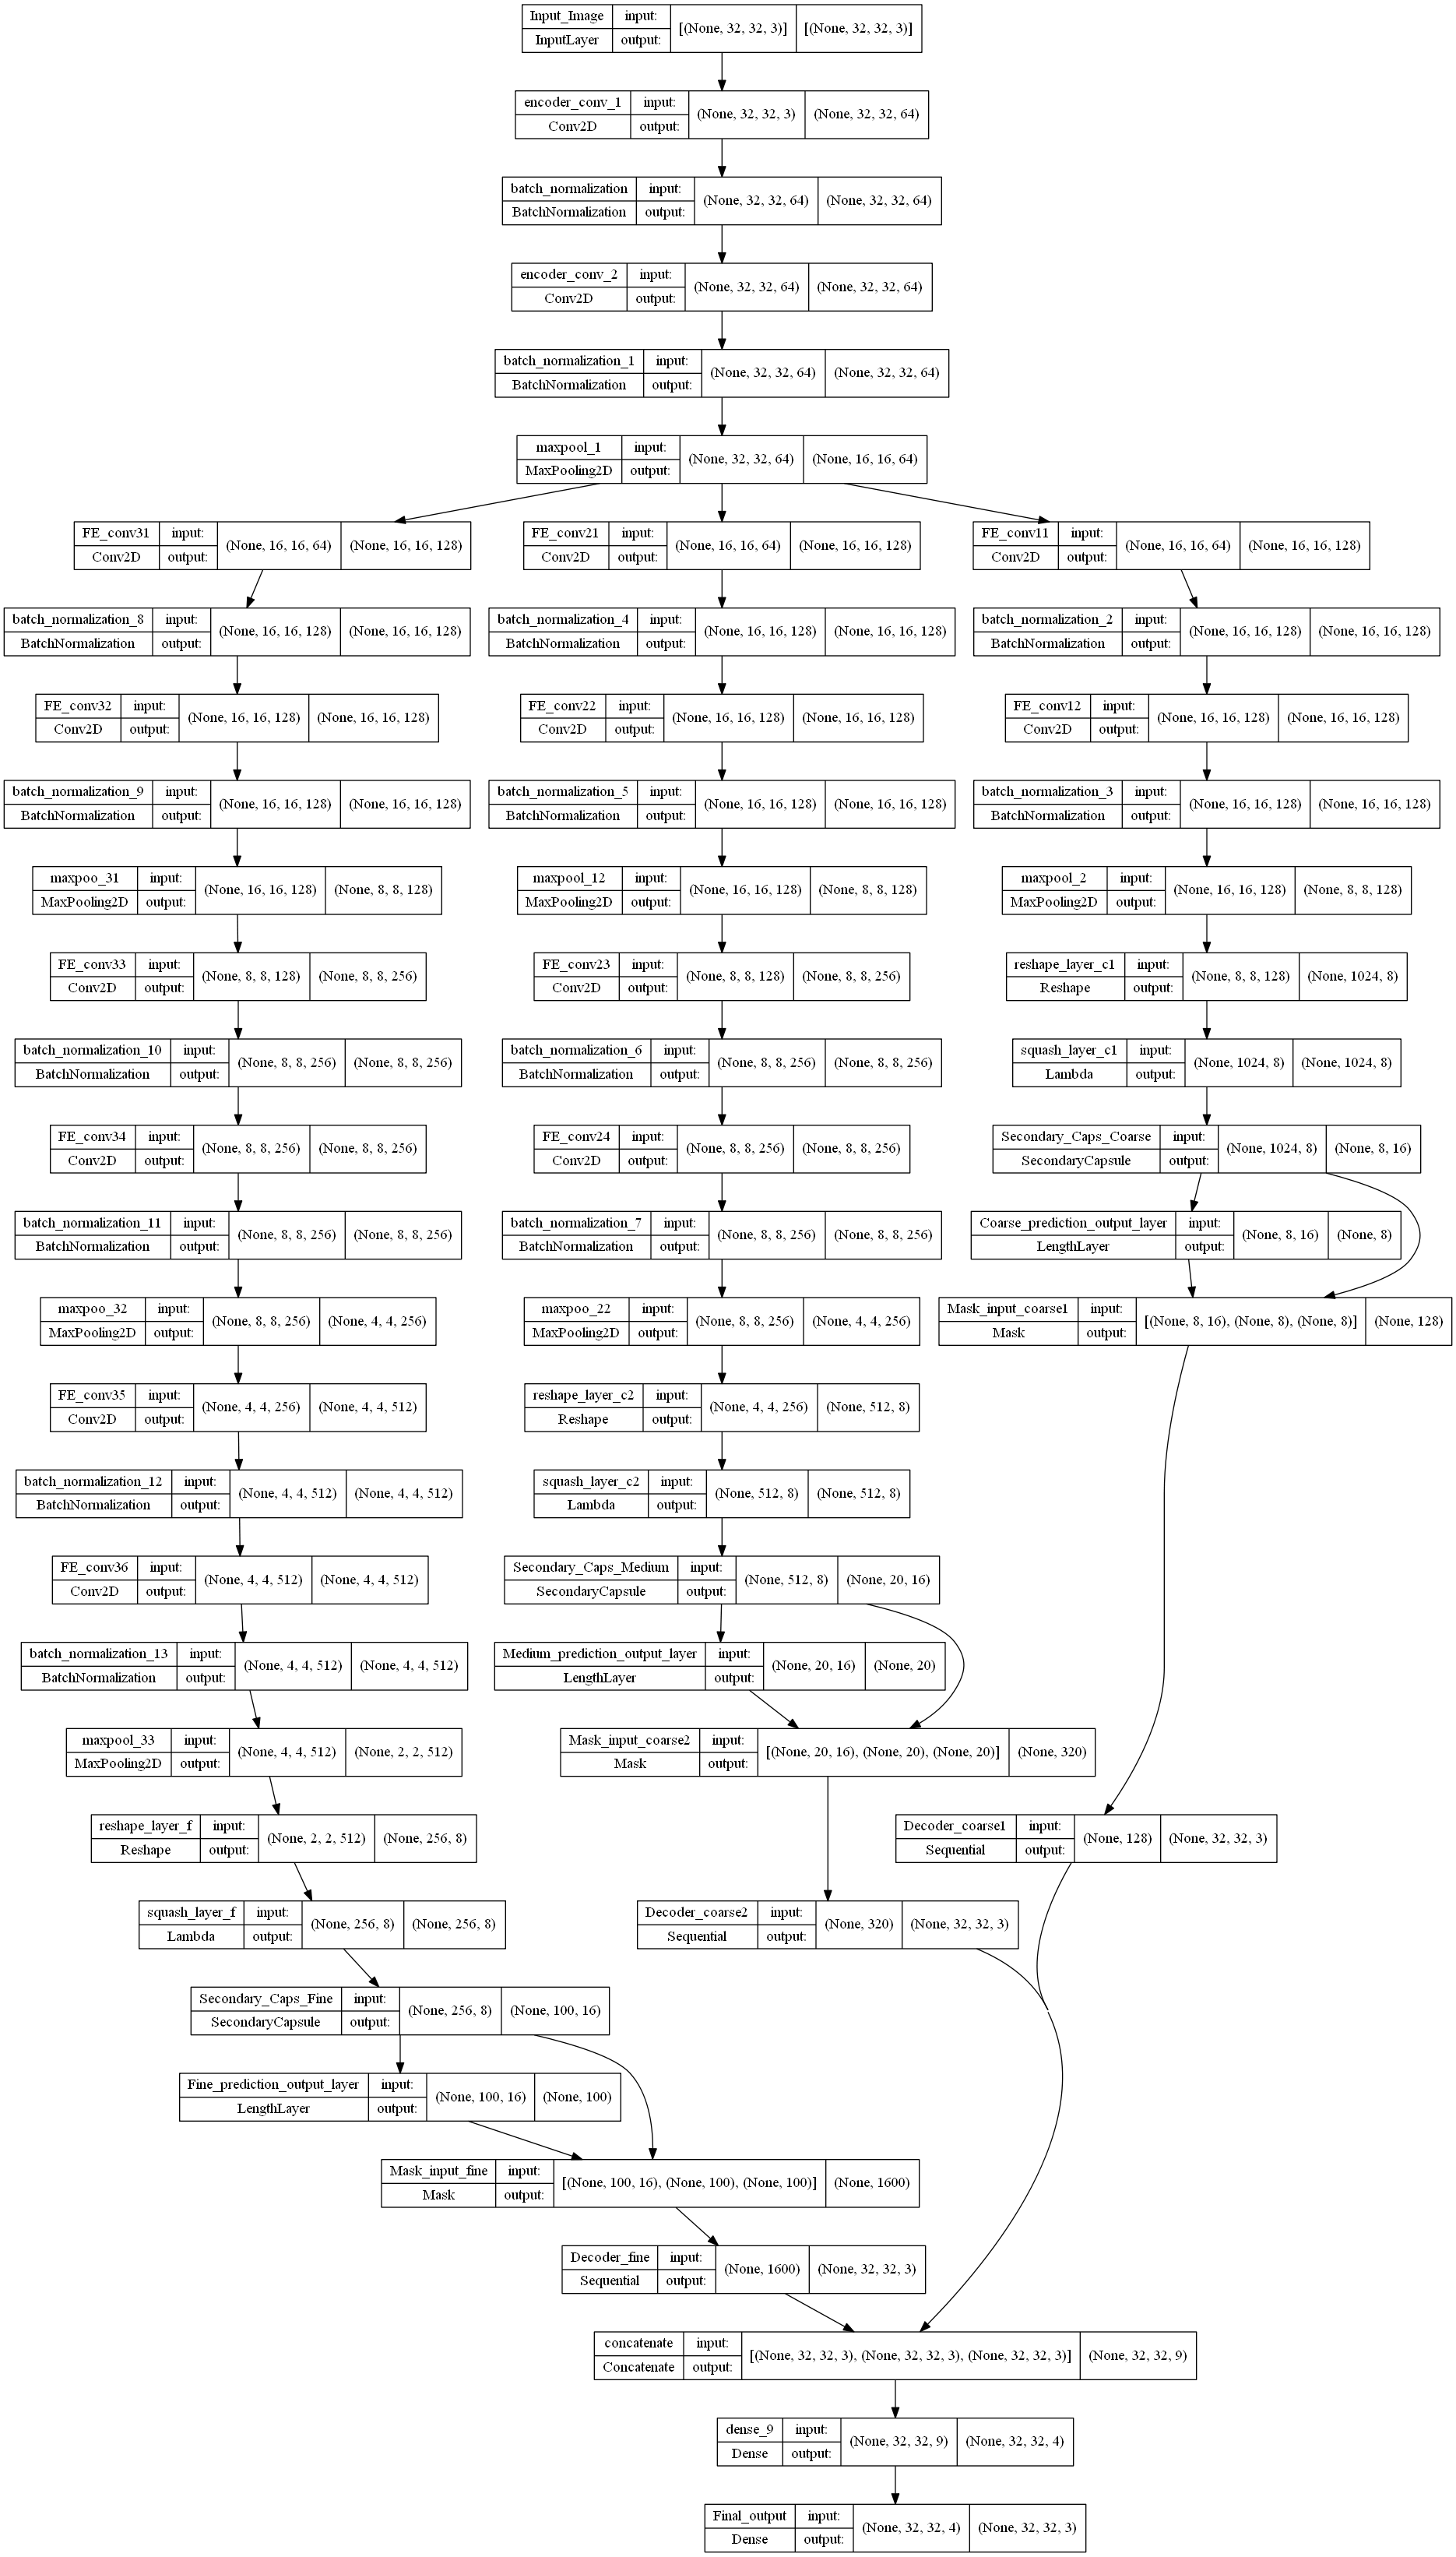

In [26]:
tf.keras.backend.clear_session() ## clear session

model = get_compiled_model()

### Log directory
directory = sysenv.log_dir(dataset["name"]+'/'+model.name)

model.summary()
keras.utils.plot_model(model, to_file = directory+"/H-CapsNet.png", show_shapes=True)

## Model load weight

In [27]:
model.load_weights(directory+'/trained_model.h5')

## Model Analysis

313/313 [==============================] - 12s 35ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 587   24   32   43  271   12   12   19]
 [   8 1290   40   52   75   20    4   11]
 [  15   28 1288   27   57   23   15   47]
 [  26   36   50  715  151    4    3   15]
 [  71   32   68  111 2147   20   15   36]
 [  18   39   44   10   58  787    0   44]
 [   6   18   32   22   50    2  367    3]
 [  16    5   34   18   46   31    0  850]]

  • MEDIUM LEVEL 
[[323  21   0   0   4   8   4   5  12   3   3  12  19  15   3  32  24   0
    7   5]
 [ 33 351   7   3   4   8   2   6   1   1   6   4   9   9   9  28  12   1
    4   2]
 [  1   3 438   4  16   2   6  15   0   1   1   2   0   6   1   2   0   1
    1   0]
 [  1   3   4 399  11  28   7   3   3   5   0   2   1  11   5   2   3   0
    4   8]
 [  1   4  18   9 403   8   1   8   7   2   1   5   1  13   2   8   3   3
    2   1]
 [  3   7   1  21   7 373  17   5   4   9   4   5   2   8  10   7   3   2
    6   6]
 [  5   2   3  15   2  19 409   6   4   6   1   1   1   3   5   3   1   0
    7   7]


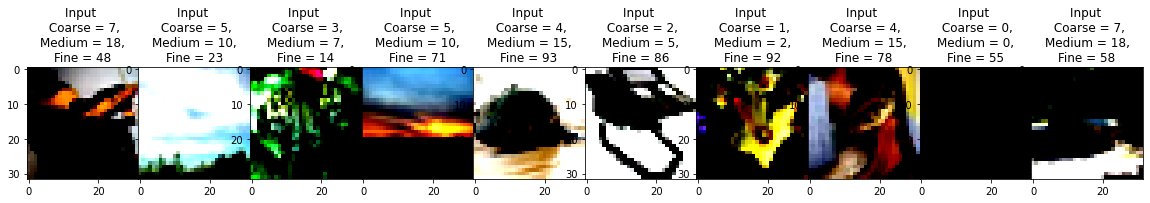

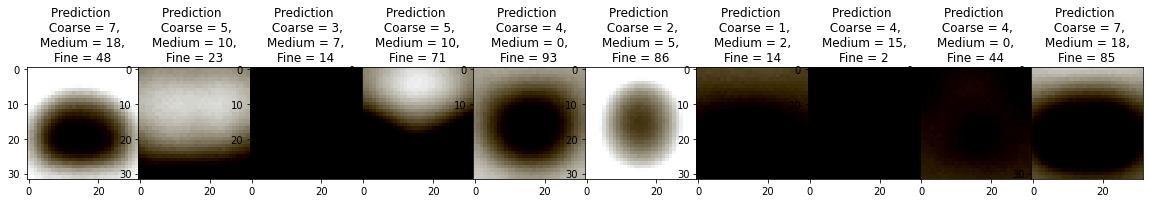

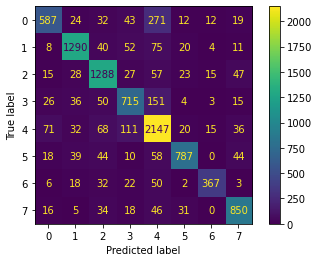

              precision    recall  f1-score   support

           0    0.78581   0.58700   0.67201      1000
           1    0.87636   0.86000   0.86810      1500
           2    0.81108   0.85867   0.83420      1500
           3    0.71643   0.71500   0.71572      1000
           4    0.75201   0.85880   0.80187      2500
           5    0.87542   0.78700   0.82886      1000
           6    0.88221   0.73400   0.80131       500
           7    0.82927   0.85000   0.83951      1000

    accuracy                        0.80310     10000
   macro avg    0.81607   0.78131   0.79520     10000
weighted avg    0.80592   0.80310   0.80149     10000


  • MEDIUM LEVEL 


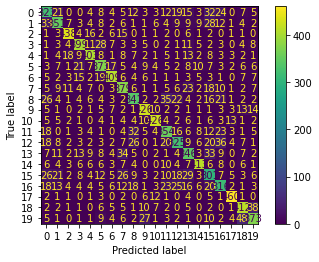

              precision    recall  f1-score   support

           0    0.63333   0.64600   0.63960       500
           1    0.74522   0.70200   0.72297       500
           2    0.87425   0.87600   0.87512       500
           3    0.79641   0.79800   0.79720       500
           4    0.81911   0.80600   0.81250       500
           5    0.72852   0.74600   0.73715       500
           6    0.83640   0.81800   0.82710       500
           7    0.70446   0.75800   0.73025       500
           8    0.71042   0.68200   0.69592       500
           9    0.82239   0.85200   0.83694       500
          10    0.87474   0.85200   0.86322       500
          11    0.70659   0.70800   0.70729       500
          12    0.70806   0.65000   0.67779       500
          13    0.66284   0.69200   0.67710       500
          14    0.86042   0.82600   0.84286       500
          15    0.56579   0.60200   0.58333       500
          16    0.65155   0.63200   0.64162       500
          17    0.91270   0

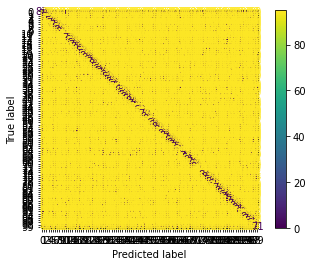

              precision    recall  f1-score   support

           0    0.83838   0.83000   0.83417       100
           1    0.75758   0.75000   0.75377       100
           2    0.47748   0.53000   0.50237       100
           3    0.46392   0.45000   0.45685       100
           4    0.53191   0.50000   0.51546       100
           5    0.71429   0.70000   0.70707       100
           6    0.74038   0.77000   0.75490       100
           7    0.66990   0.69000   0.67980       100
           8    0.74783   0.86000   0.80000       100
           9    0.85263   0.81000   0.83077       100
          10    0.48958   0.47000   0.47959       100
          11    0.43878   0.43000   0.43434       100
          12    0.72277   0.73000   0.72637       100
          13    0.67391   0.62000   0.64583       100
          14    0.59091   0.65000   0.61905       100
          15    0.60000   0.72000   0.65455       100
          16    0.69231   0.72000   0.70588       100
          17    0.88172   0

In [28]:
results = model.evaluate(dataset['x_test'],
                         [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine'],dataset['x_test']],
                         verbose=1)
predictions = model.predict(dataset['x_test'],verbose=1)

MLmodel.plot_sample_image(predictions,
                  x_input = dataset['x_test'],
                  y_labels = {'coarse':dataset['y_test_coarse'],
                              'medium':dataset['y_test_medium'],
                              'fine':dataset['y_test_fine']})

true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,pred_label,dataset['tree'])

print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )

# Marine Tree Dataset

## Import Dataset

In [29]:
dataset = datasets.get_Marine_dataset(output_level='level_depth_3',
                                      dataset_path ='D:\Datasets\Marine_tree', ## Path to the dataset directory
                                      image_size=(64,64),
                                      batch_size=train_params['batch_size'],
                                      subtype='Combined',
                                      data_normalizing ='normalize',
                                      class_encoding = 'One_Hot_Encoder',
                                      data_augmantation = 'mixup'
                                     )

## Model parameters

In [30]:
coarse_class, medium_class, fine_class = dataset.num_classes

initial_lw = MLmodel.initial_lw({"coarse": coarse_class,
                                 "medium": medium_class,
                                 "fine": fine_class})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : model_params['Reconstruction_LW']
             }

## Get model

In [31]:
def get_compiled_model():
    model = MLmodel.HCapsNet_3_Level_test(input_shape = dataset.image_size,
                                        no_coarse_class  = coarse_class,
                                        no_medium_class  = medium_class,
                                        no_fine_class    = fine_class
                                       )
    model.compile(optimizer='adam',
                  loss=[model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["reconstruction_loss"]],
                  loss_weights=[lossweight['coarse_lw'],
                                lossweight['medium_lw'],
                                lossweight['fine_lw'],
                                lossweight['decoder_lw']],
                  metrics={'Fine_prediction_output_layer': 'accuracy',
                           'Medium_prediction_output_layer': 'accuracy',
                           'Coarse_prediction_output_layer': 'accuracy'}
                 )
    return model

In [32]:
tf.keras.backend.clear_session() ## clear session

In [33]:
model = get_compiled_model()

Model: "H-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 64, 64, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['encoder_conv_1[0][0]']         
 alization)                                                                                       
                                                                                                  
 encoder_conv_2 (Conv2D)        (None, 64, 64, 64)   36928       ['batch_normalization[0][

 maxpool_2 (MaxPooling2D)       (None, 16, 16, 128)  0           ['batch_normalization_3[0][0]']  
                                                                                                  
 maxpoo_22 (MaxPooling2D)       (None, 8, 8, 256)    0           ['batch_normalization_7[0][0]']  
                                                                                                  
 maxpool_33 (MaxPooling2D)      (None, 4, 4, 512)    0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 reshape_layer_c1 (Reshape)     (None, 4096, 8)      0           ['maxpool_2[0][0]']              
                                                                                                  
 reshape_layer_c2 (Reshape)     (None, 2048, 8)      0           ['maxpoo_22[0][0]']              
                                                                                                  
 reshape_l

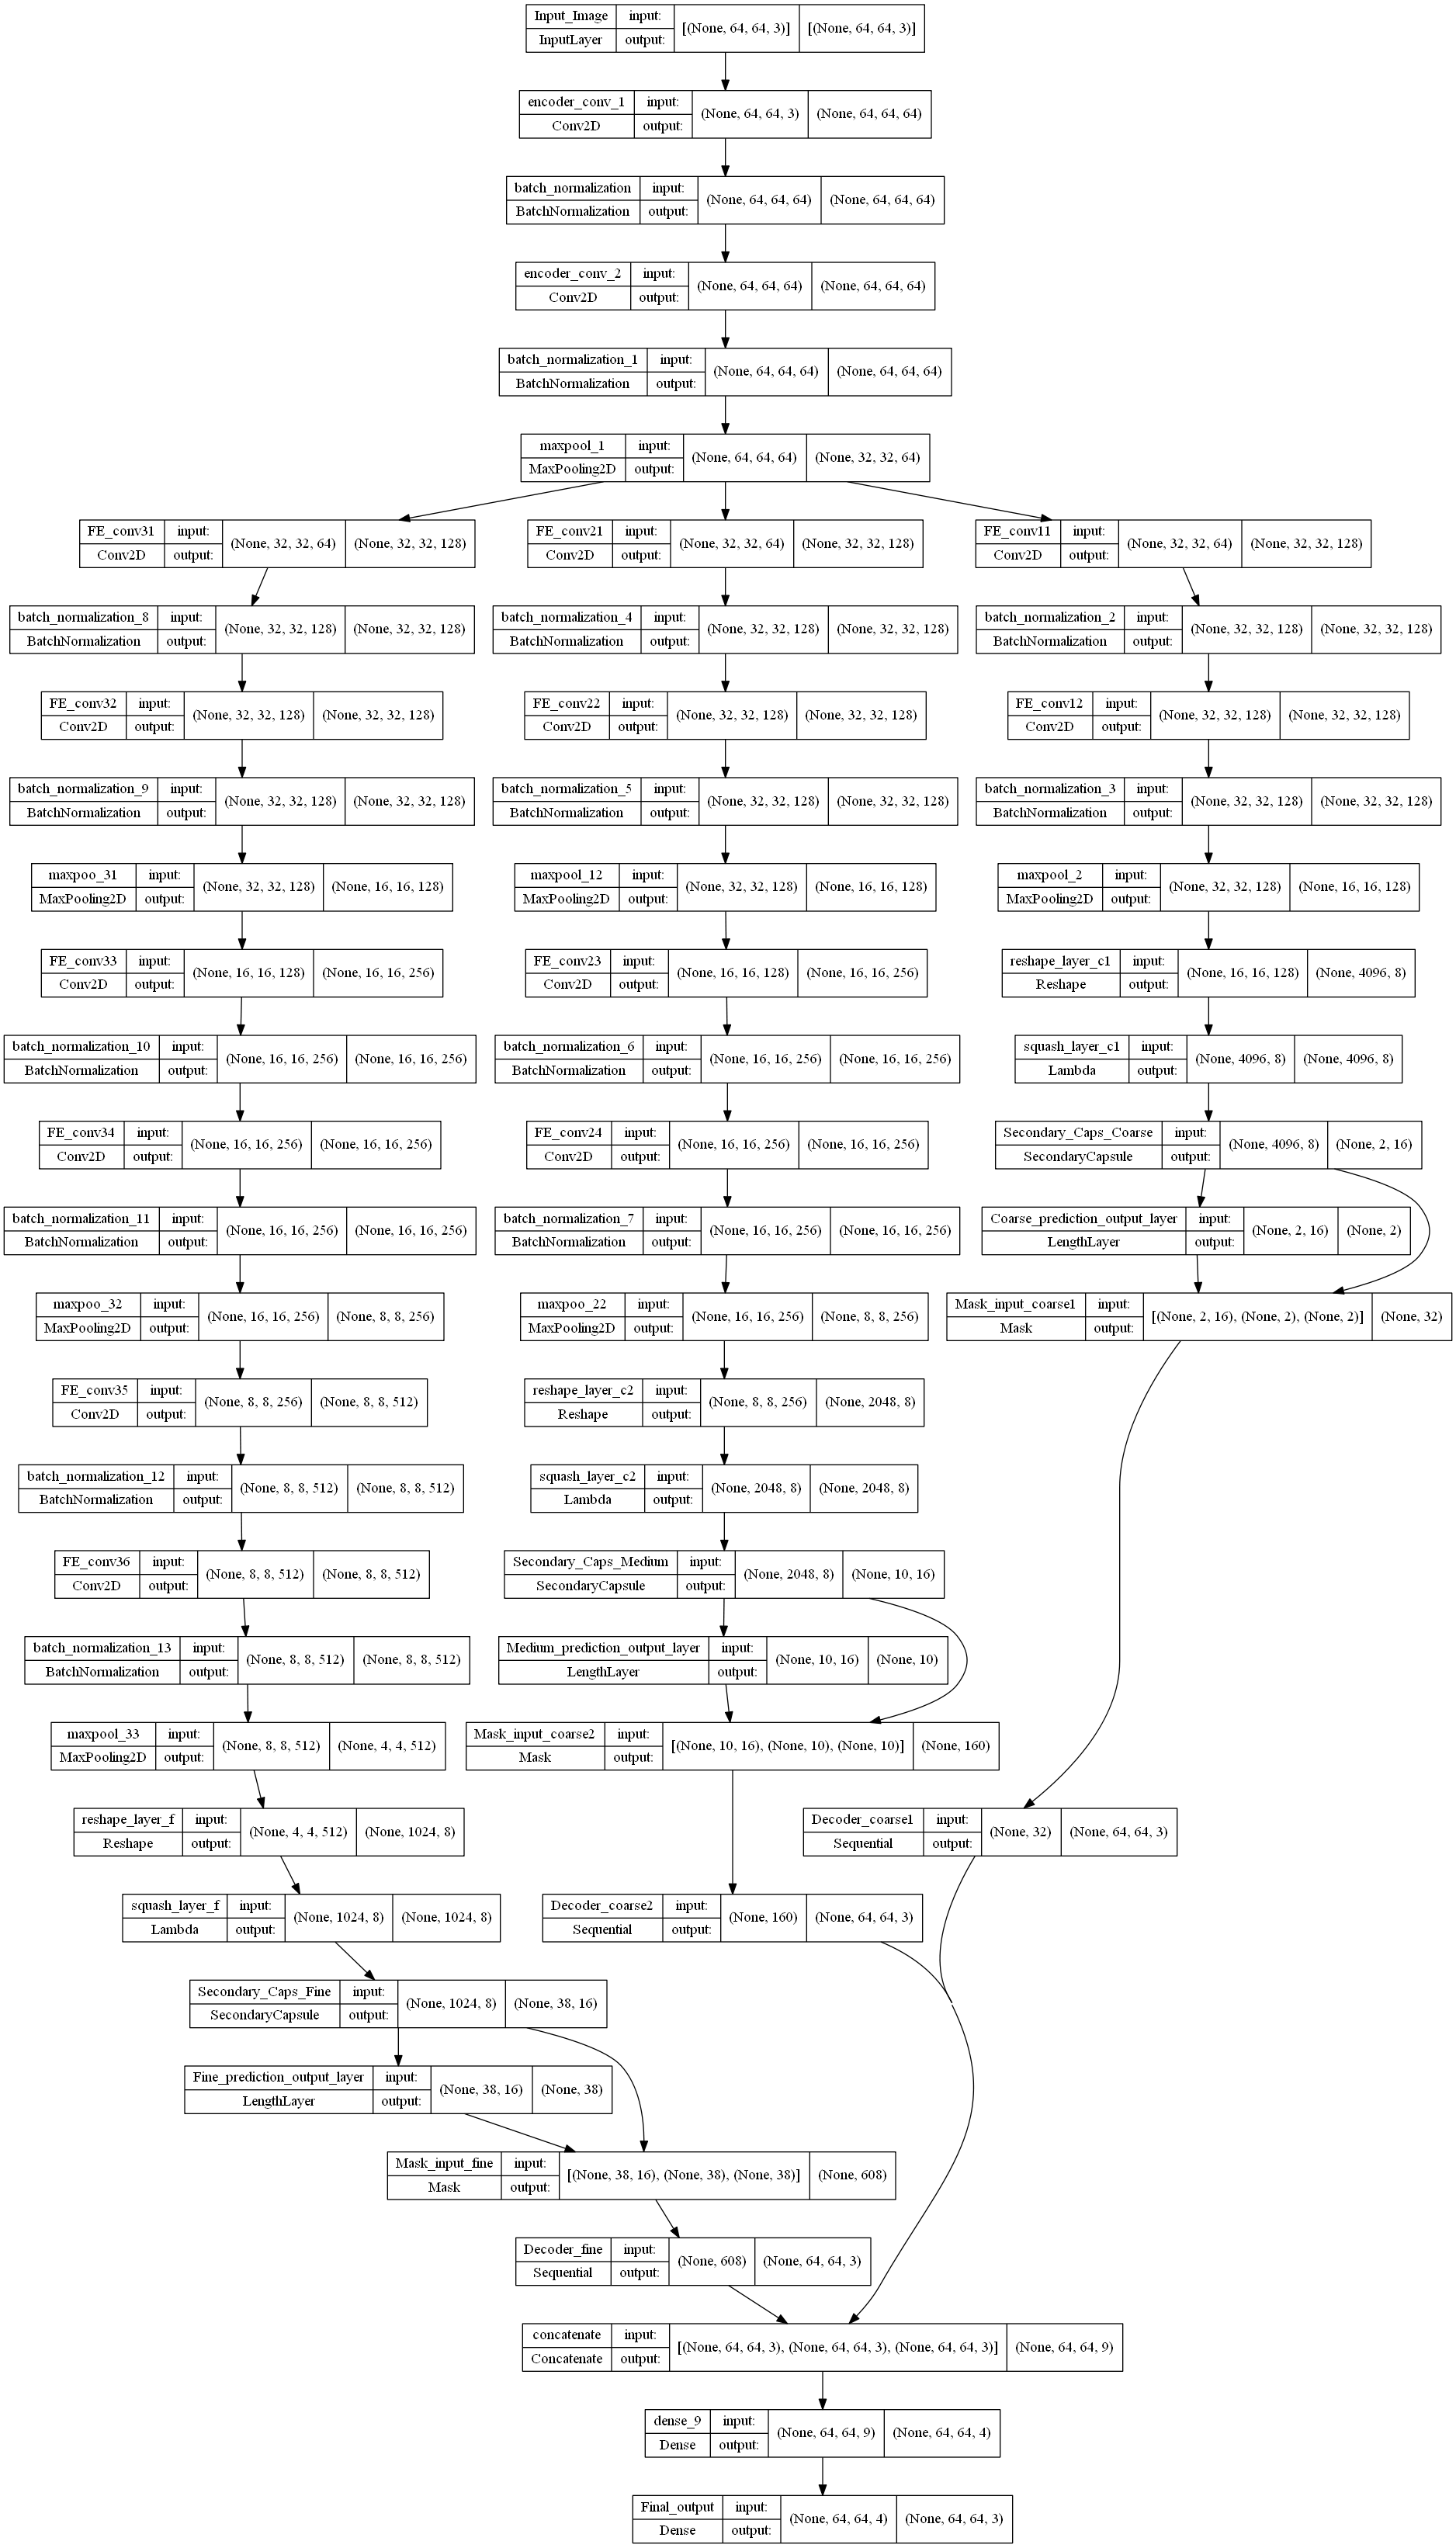

In [34]:
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## Log Directory

In [35]:
### Log directory
directory = sysenv.log_dir(dataset.name+'/'+model.name)

## Dataset Pipeline

In [36]:
def pipeline_multi_input_output(image, label):
    label_0 = label[0]
    label_1 = label[1]
    label_2 = label[2]
    return image, (label_0, label_1, label_2, image)

### matchin X,Y with model input
test_dataset_match = dataset.test_dataset.map(pipeline_multi_input_output) ## test Dataset

## Load Model Weight

In [37]:
model.load_weights(directory+'/Trained_Model.h5')

## Model Analysis

In [38]:
results = model.evaluate(test_dataset_match)
for n in range(len(results)):
    print(str(n+1)+'.',model.metrics_names[n], '==>', results[n])

838/838 [==============================] - 49s 56ms/step - loss: 0.1298 - Coarse_prediction_output_layer_loss: 0.0788 - Medium_prediction_output_layer_loss: 0.1477 - Fine_prediction_output_layer_loss: 0.2741 - Final_output_loss: 0.0404 - Coarse_prediction_output_layer_accuracy: 0.8838 - Medium_prediction_output_layer_accuracy: 0.7949 - Fine_prediction_output_layer_accuracy: 0.6244
1. loss ==> 0.12981094419956207
2. Coarse_prediction_output_layer_loss ==> 0.0787695124745369
3. Medium_prediction_output_layer_loss ==> 0.1477203518152237
4. Fine_prediction_output_layer_loss ==> 0.2741095721721649
5. Final_output_loss ==> 0.040424417704343796
6. Coarse_prediction_output_layer_accuracy ==> 0.8837599754333496
7. Medium_prediction_output_layer_accuracy ==> 0.7948727607727051
8. Fine_prediction_output_layer_accuracy ==> 0.6243749260902405


### Model predictions

In [39]:
def predict_from_pipeline(model, dataset):
    y_pred_c = []
    y_pred_m = []
    y_pred_f = []
    
    y_true_c = []
    y_true_m = []
    y_true_f = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        
        y_true_c.extend(y[0].numpy().tolist())
        y_true_m.extend(y[1].numpy().tolist())
        y_true_f.extend(y[2].numpy().tolist())
        
        y_pred_c.extend(batch_pred[0].tolist())
        y_pred_m.extend(batch_pred[1].tolist())
        y_pred_f.extend(batch_pred[2].tolist())
        
    return np.array(y_true_c), np.array(y_true_m), np.array(y_true_f), np.array(y_pred_c), np.array(y_pred_m), np.array(y_pred_f)

In [40]:
y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f = predict_from_pipeline(model, test_dataset_match)

  • Confusion_Matrix 

  • COARSE LEVEL 
[[22902   178]
 [ 2937   781]]

  • MEDIUM LEVEL 
[[  100    76     0     0     0     0    12   520     0    35]
 [   14  1191     0     0     0     0    17  1057     0    46]
 [    2     0     0     0     0     0     0    21     0     1]
 [    1     4     0    20     0     0     1    92     0     1]
 [    1     1     0     0     1     0     2    44     0     0]
 [   10    13     0     1     0     0     3   110     0     7]
 [    0     3     0     0     0     0   512   173     0     7]
 [   61   330     0    13     0     0   191 18161     0   206]
 [    1     0     0     0     0     0     0    17     0     1]
 [   13   137     0     7     0     0    21  2224     0  1316]]

  • FINE LEVEL 
[[828  14   2 ...   0  36  14]
 [ 56 275   1 ...   0   5   4]
 [ 45  54  89 ...   0   5   3]
 ...
 [  8  12   2 ...   0   5   0]
 [131  19   2 ...   0 146   9]
 [  4   1   0 ...   0   0 372]]

  • Classification Report 


  • COARSE LEVEL 


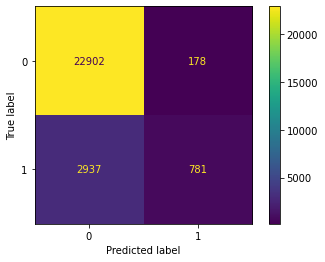

              precision    recall  f1-score   support

           0    0.88633   0.99229   0.93632     23080
           1    0.81439   0.21006   0.33397      3718

    accuracy                        0.88376     26798
   macro avg    0.85036   0.60117   0.63515     26798
weighted avg    0.87635   0.88376   0.85275     26798


  • MEDIUM LEVEL 


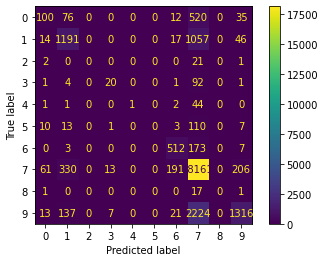

C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    0.49261   0.13459   0.21142       743
           1    0.67863   0.51226   0.58382      2325
           2    0.00000   0.00000   0.00000        24
           3    0.48780   0.16807   0.25000       119
           4    1.00000   0.02041   0.04000        49
           5    0.00000   0.00000   0.00000       144
           6    0.67457   0.73669   0.70426       695
           7    0.81007   0.95776   0.87775     18962
           8    0.00000   0.00000   0.00000        19
           9    0.81235   0.35395   0.49307      3718

    accuracy                        0.79487     26798
   macro avg    0.49560   0.28837   0.31603     26798
weighted avg    0.77993   0.79487   0.76546     26798


  • FINE LEVEL 


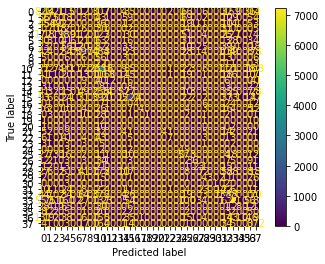

              precision    recall  f1-score   support

           0    0.35385   0.50488   0.41608      1640
           1    0.50366   0.51887   0.51115       530
           2    0.67939   0.28344   0.40000       314
           3    0.51429   0.16981   0.25532       106
           4    0.51164   0.62834   0.56401      1574
           5    0.75000   0.02459   0.04762       244
           6    0.54545   0.04152   0.07717       289
           7    0.57020   0.40502   0.47362      1474
           8    0.00000   0.00000   0.00000        96
           9    0.00000   0.00000   0.00000        30
          10    0.43933   0.80024   0.56725      3294
          11    0.52679   0.27570   0.36196       428
          12    1.00000   0.01887   0.03704       106
          13    0.00000   0.00000   0.00000        31
          14    0.42222   0.09913   0.16056       575
          15    0.71537   0.62385   0.66649      1962
          16    1.00000   0.13793   0.24242        29
          17    0.80000   0

C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
metrics.lvl_wise_metric([y_true_c, y_true_m, y_true_f],
                        [y_pred_c, y_pred_m, y_pred_f])

In [42]:
h_measurements,consistency,exact_match = metrics.hmeasurements([y_true_c, y_true_m, y_true_f],
                                                               [y_pred_c, y_pred_m, y_pred_f],
                                                               dataset.get_tree())
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.769317983929149 
Hierarchical Recall = 0.809662412617857 
Hierarchical F1-Score = 0.7854188656580626 
Consistency =  0.8306590044033136 
Exact Match =  0.5484737666990074
